# bigram

```
1. hyperparameter

```

In [2]:

import torch
import torch.nn as nn # give nn.Linear → stateful function (has weights, updates during training)
from torch.nn import functional as F # give F.softmax, F.cross_entropy → stateless function (just math, no memory, just compute and leave 😤)

#=================hyperparameter============================

batch_size = 16            # 👉 one forward pass = 16 independent sequences will we process in parallel
context_length = 4         # what is the maximum context length/block_size for predictions next token?
max_iters = 100            # Total training steps, (More steps = more learning)
learning_rate = 1e-2       # 1 x 10^-2 = 0.01. 👉 If the gradient is a compass telling you which way is downhill, the learning rate is the length of your stride
eval_interval = 10         # After how many steps we check loss (To see if model is improving)
eval_iters = 20            # its only only for evaluation, not training. when we estimate loss, we don’t trust one batch.👉 we compute loss on 200 different batches 👉 then average them , One batch can be noisy 🎲, BUT 200 batches ≈ more stable, honest loss

device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(1337)



cpu


>>> 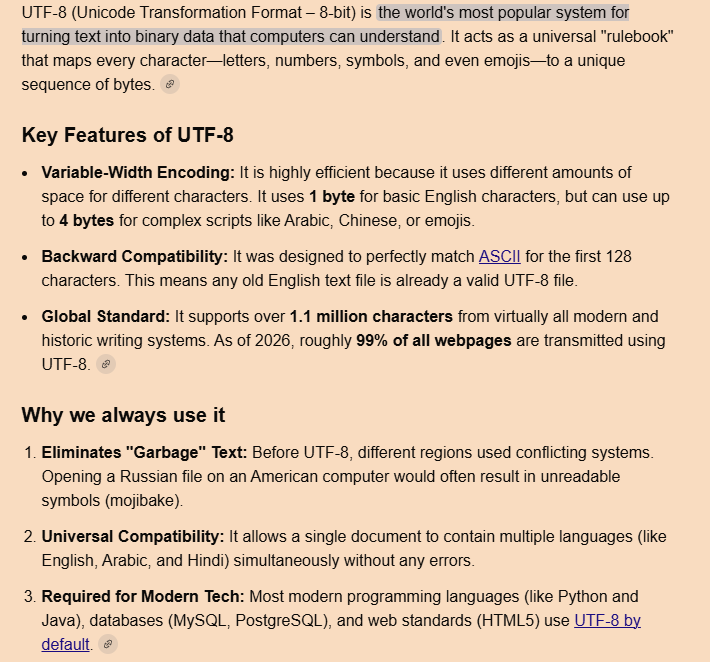

```
 2. load the data
```

In [3]:
# load english translation of quran
with open("quran_en.txt", "r", encoding="utf-8") as f:
    quran_en = f.read()
    print(quran_en[:100])
    print(len(quran_en))
    print(set(quran_en))
    print(len(set(quran_en)))

In the name of Allah, the Entirely Merciful, the Especially Merciful.
[All] praise is [due] to Allah
861583
{'w', 'V', 'Y', 'e', 'f', '(', ';', ']', 'a', 's', 'l', '\n', 'G', '.', 'T', 'M', 'K', 'I', 'S', 'Z', 'm', ',', 'j', 'z', 'b', '!', '?', 'h', ')', 't', 'Q', 'n', '"', 'E', 'U', 'N', 'v', ' ', 'd', 'F', 'c', 'C', ':', 'r', 'o', 'u', 'p', 'y', 'i', 'k', 'W', 'H', 'O', '[', "'", 'J', 'x', 'A', 'D', 'L', '-', 'P', 'R', 'g', 'q', 'B'}
66


>>> 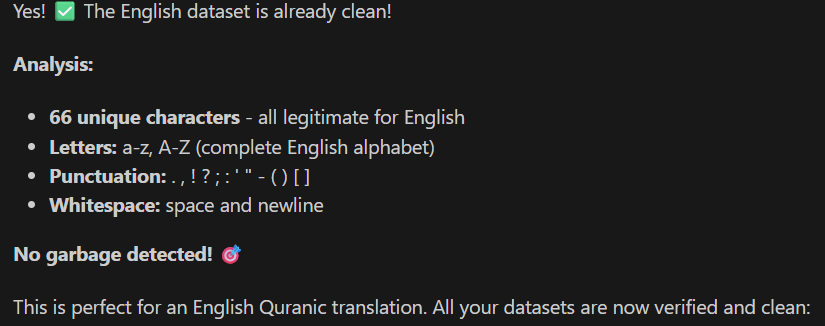

In [4]:
total_char = len(quran_en)
print(total_char)
chars =  sorted(set(quran_en))
print(chars) # here i keep letters + punctuation + space + newline. bez for text generation we need text as hooman(oh it me 🤧) write.
vocab_size = len(chars)
vocab_size # my vocab size = 66 

861583
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


66

```
hummmmmmmm 🤧 bez neural net 👀 dont understand char he need number 😤🔢 so means i need to do tokenization 
```

In [5]:
# mapping a reversible bridge: text/chars  ⇄  integers
stoi = {ch:i for i, ch in enumerate(chars)} # for machine 🎰, enumerate(): A built-in function that takes a list and returns pairs of (index, element).
print(stoi)
itos = {i:ch for i,ch in enumerate(chars)} # for hooman 👱(again it's me 🤧)
print(itos)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'Y': 36, 'Z': 37, '[': 38, ']': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'Y', 37: 'Z', 38: '[', 39: ']', 40: 'a', 41: 'b', 42: 'c', 43: 'd', 44: 'e', 45: 'f', 46: 'g',

>>> 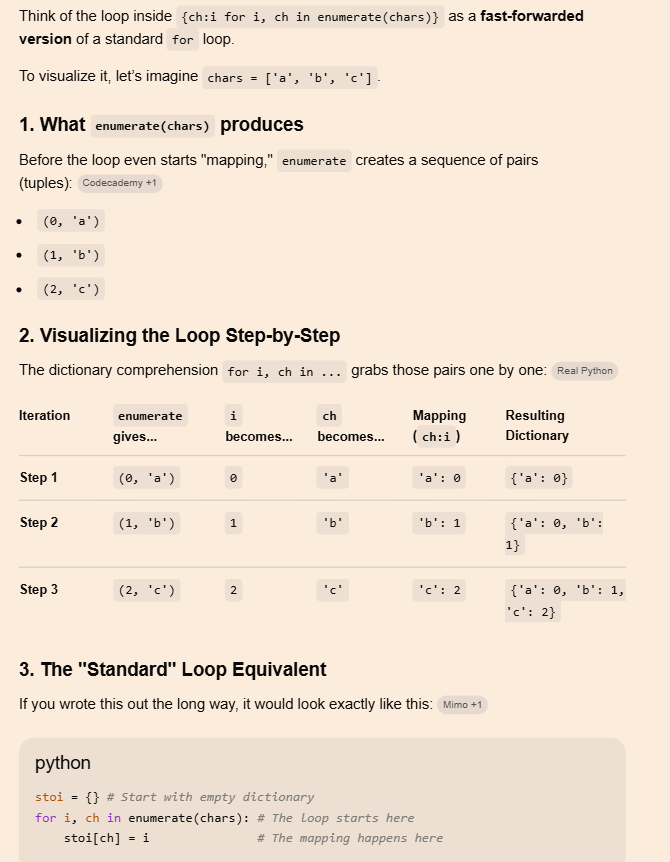

>>> 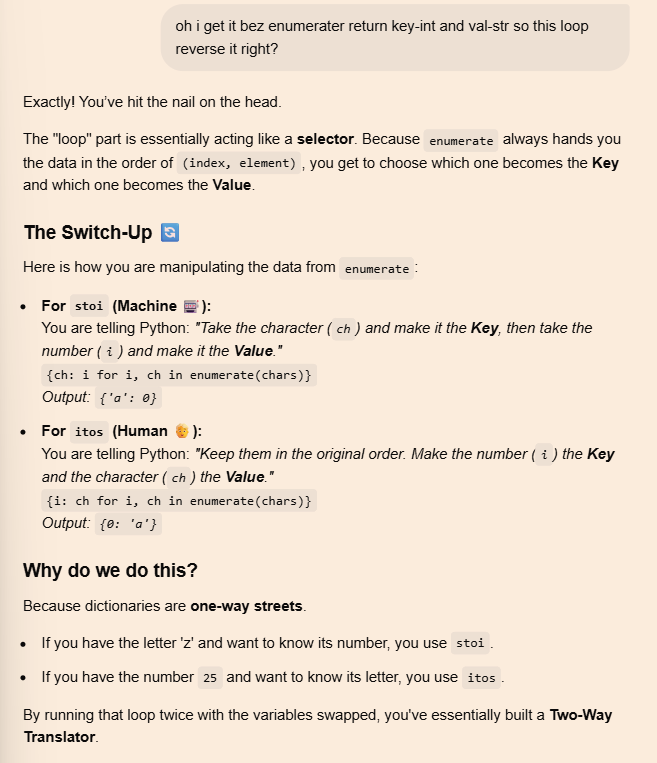

In [6]:
# encoder - take str as input and give me output list of int 
encoder = lambda s: [stoi[c] for c in s] # lambda arguments: expression . -------> a lambda function is a small, anonymous function defined without a name. While regular functions use the def keyword, lambdas use the lambda keyword and are typically used for short-lived, "throwaway" operations.
# decoder - take a list of int and give me output as string 
decoder = lambda l: ''.join([itos[i] for i in l])


>>> 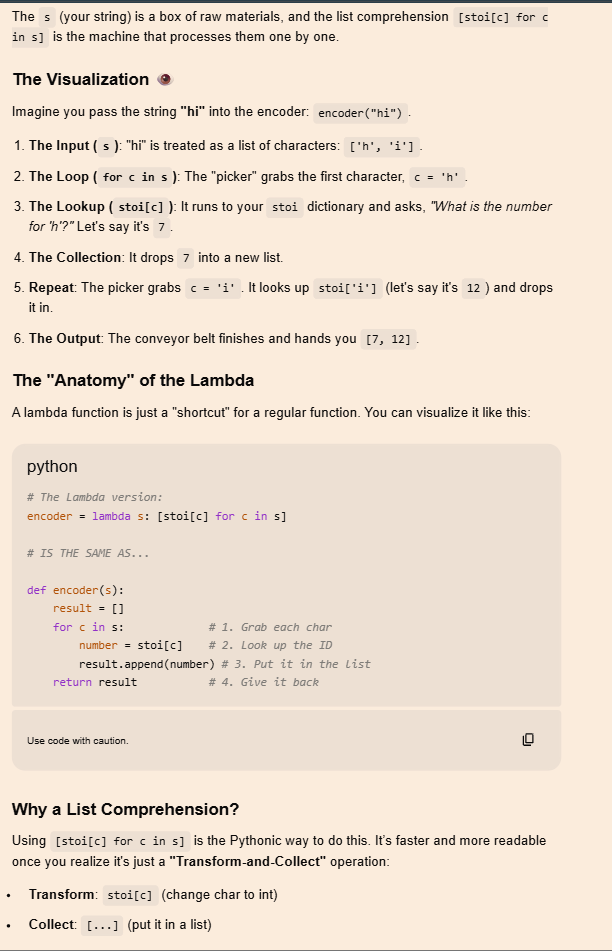

>>> 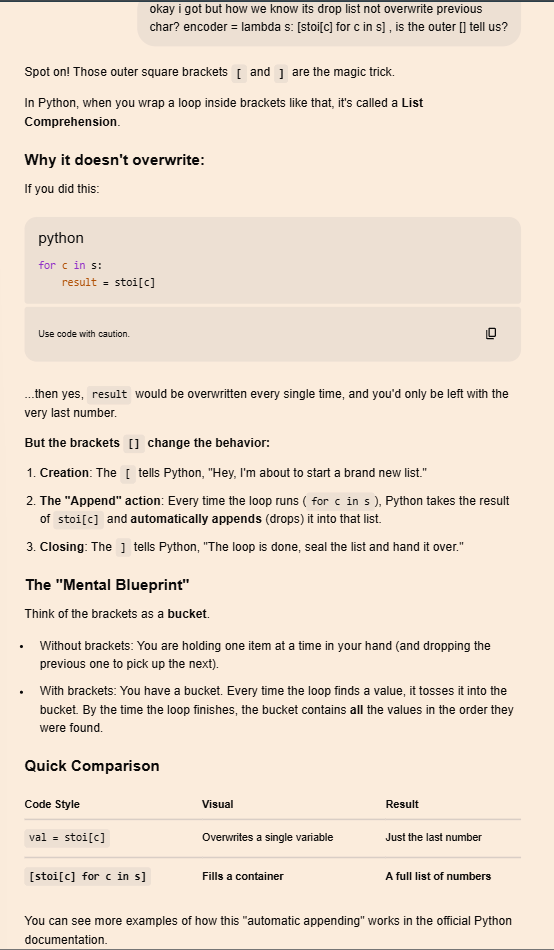

>>> 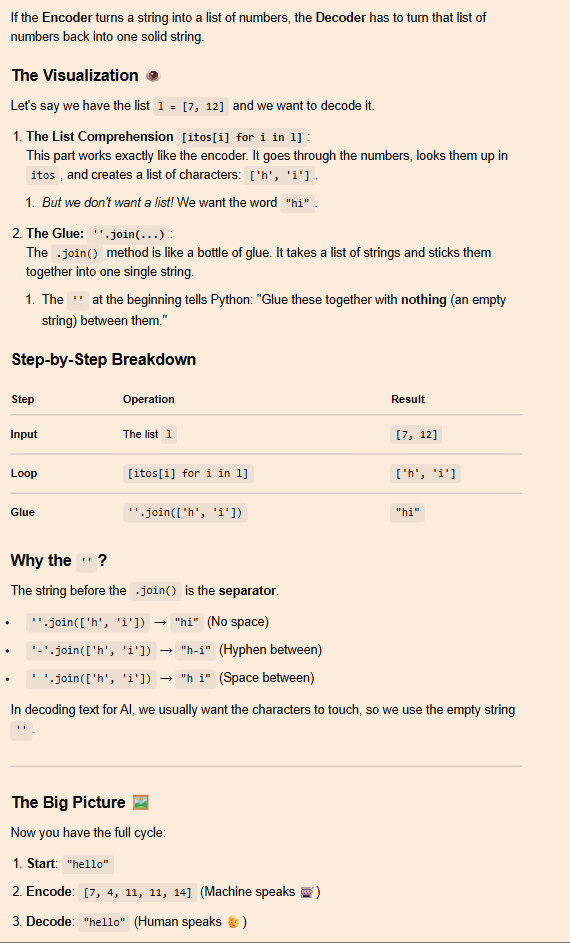

In [7]:
# testing 🧪 encoder and decoder is working right or not ?
encoder_name = encoder("Farhan")
decoder_name = decoder(encoder_name)


print(f"Encoded:   {encoder_name}  <-- The 'Machine' 🎰 sees this")
print(f"Decoded:   {decoder_name}  <-- The 'Hooman' 👱 sees this(yeah i know it's me🤧)")

Encoded:   [18, 40, 57, 47, 40, 53]  <-- The 'Machine' 🎰 sees this
Decoded:   Farhan  <-- The 'Hooman' 👱 sees this(yeah i know it's me🤧)


In [8]:
# verify by  its by index 
encoded_f = encoder("a") 
print(encoded_f) 
# itos dict to look up the character by its index
character_f = itos[40]
print(character_f) 


[40]
a


```
 3. train and test split
```

In [9]:
len(quran_en)

861583

In [10]:
data = torch.tensor(encoder(quran_en), dtype=torch.long)
n = int(0.9 * len(data)) # len(data) = total number of characters which is here (861583), 0.9 * len(data) = 90% of the data, int(...) = make it a whole number (index)
training_data = data[:n]
print(len(training_data))
validation_data = data[n:]
print(len(validation_data))



775424
86159


In [11]:
%%capture
"""
CONCEPTS: DATA SPLITTING & DTYPES IN BIGRAM MODELS
--------------------------------------------------

1. WHY MANUAL SPLIT INSTEAD OF SCIKIT-LEARN?
   - Sequential Integrity: Language models predict the 'next' token. BUT Scikit-learn's 
     train_test_split() shuffles data by default. Shuffling raw text breaks the 
     natural order, leading to "Data Leakage" (the model sees the future to 
     predict the past). Slicing [data[:n]] preserves the sequence.
   - Zero Dependencies: Building from scratch (Karpathy's style) avoids extra 
     libraries for simple operations like slicing.

2. WHY torch.long INSTEAD OF fp32?
   - Categorical vs. Continuous: 'fp32' is for model weights (math). 'torch.long' 
     (64-bit integer) is for token indices/IDs (categories).
   - PyTorch Requirements: Layers like nn.Embedding and nn.CrossEntropyLoss 
     strictly require LongTensors for input indices and target labels.
   - Lookup Addresses: Think of tokens as "addresses" in a library. You don't 
     search for "Book 5.5"; you search for "Book 5" or "Book 6".
"""

>>> 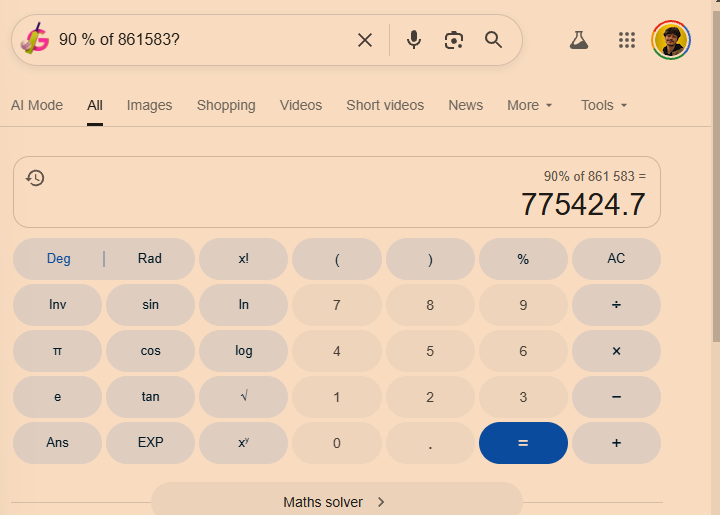
>>> 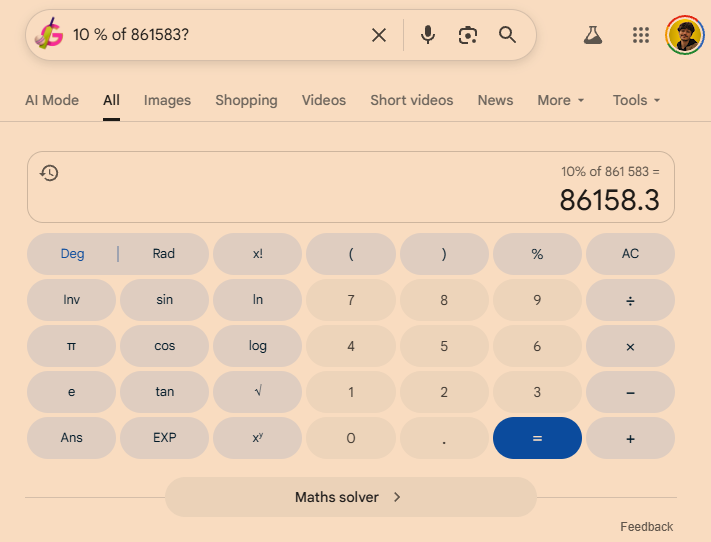

```
4. bez i now split my data i have data in a format that can machine understand so next i need to do load that data and give model ofcourse I don't load all data at once  bez that make computaion very heavy 🤧😭 so i need  to send data in in batches bcz gpu love 😻 parallel computaion🎰. 
```

In [12]:
# load data 
# 👉 here i defines a simple function that returns one training batch
def get_batch(split):
    data = training_data if split == 'train' else validation_data # which data model see?
    ix = torch.randint(len(data) - context_length, (batch_size,))  # ix is a shorthand for "Indices" (plural of Index). In my code, ix is a Tensor of 16 random starting positions.
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x,y

    

In [13]:
print(len(data)) #861583
print(context_length) # block_size, 4
print(batch_size) # 16

861583
4
16


>>> 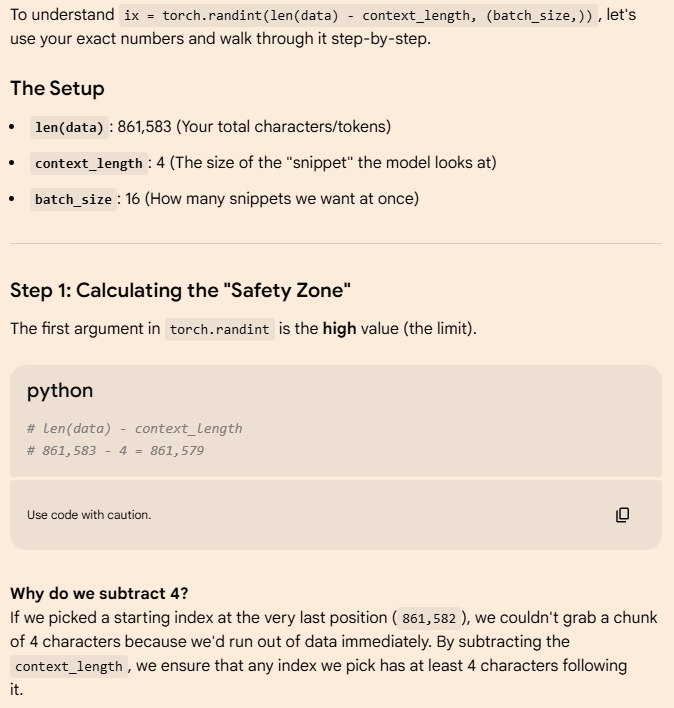

>>> 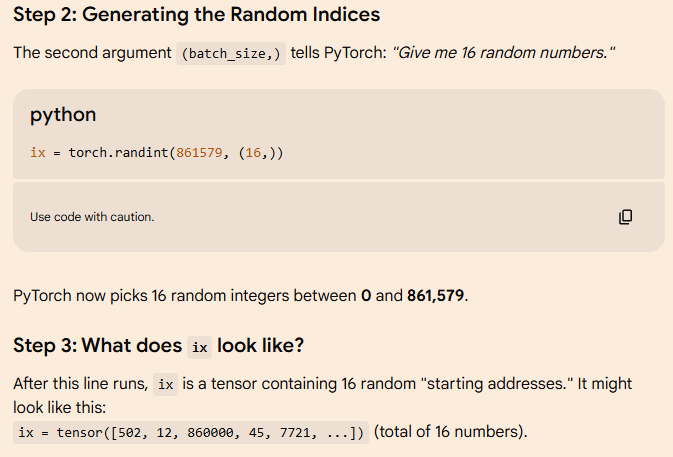

>>> 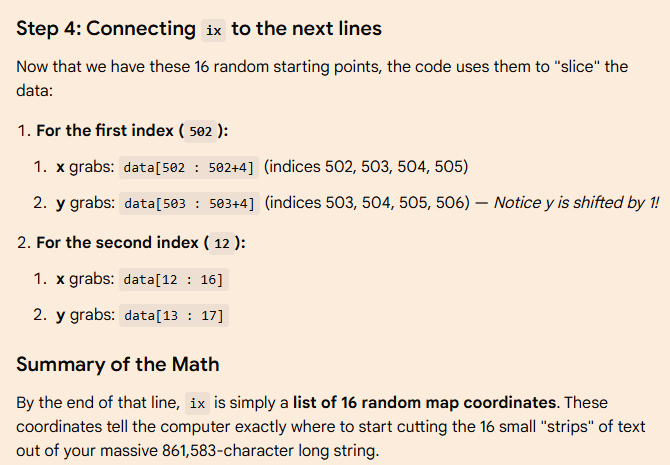

>>> 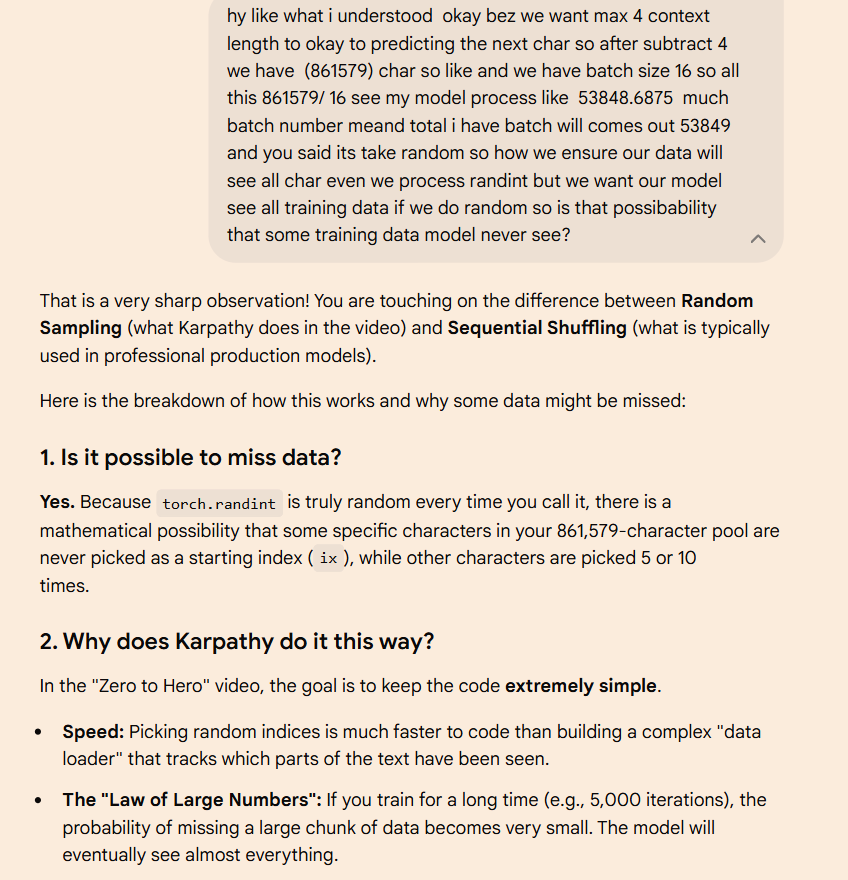

>>> 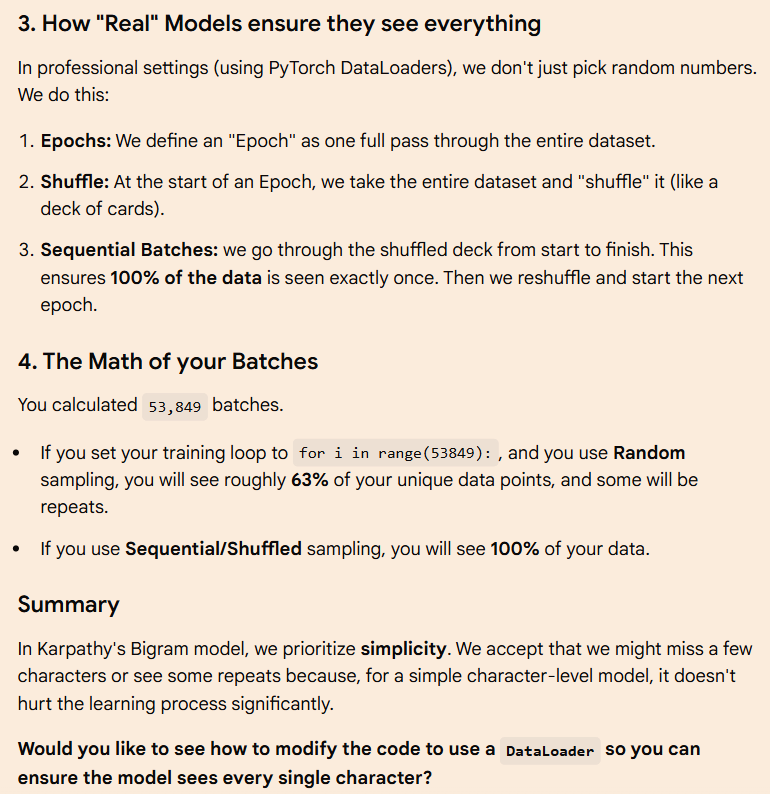

>>> 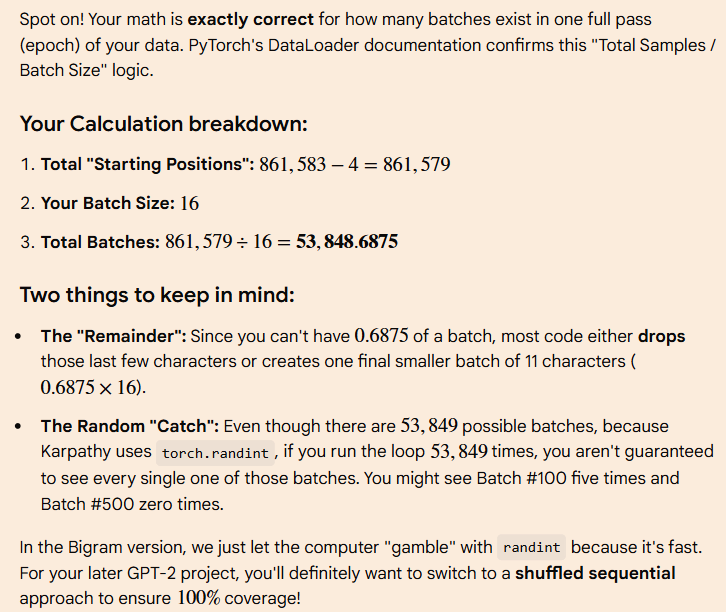


>>> 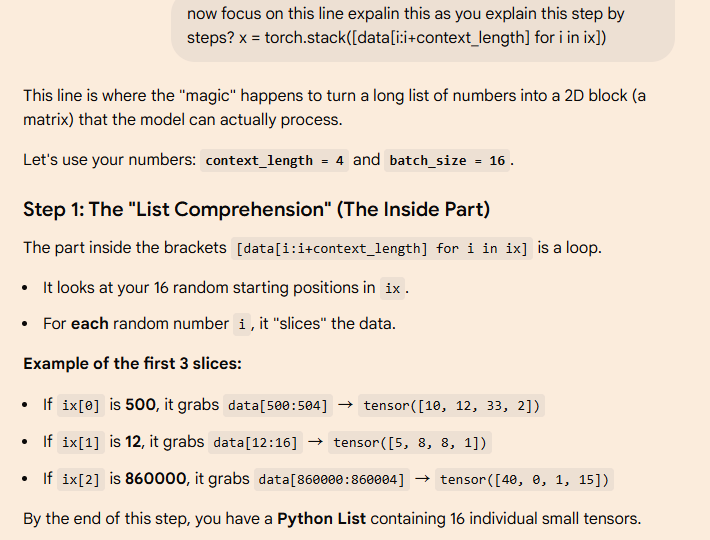

>>> 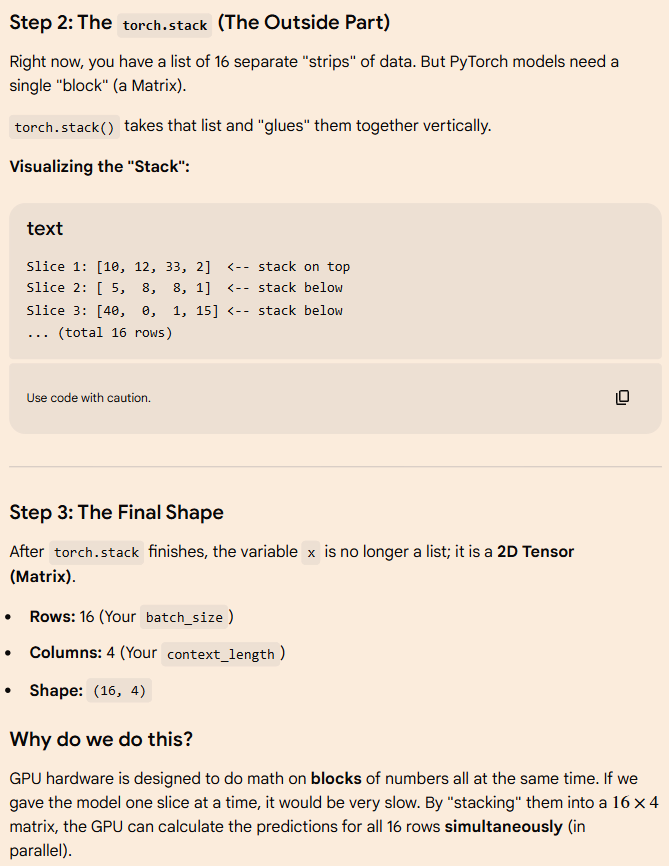

>>> 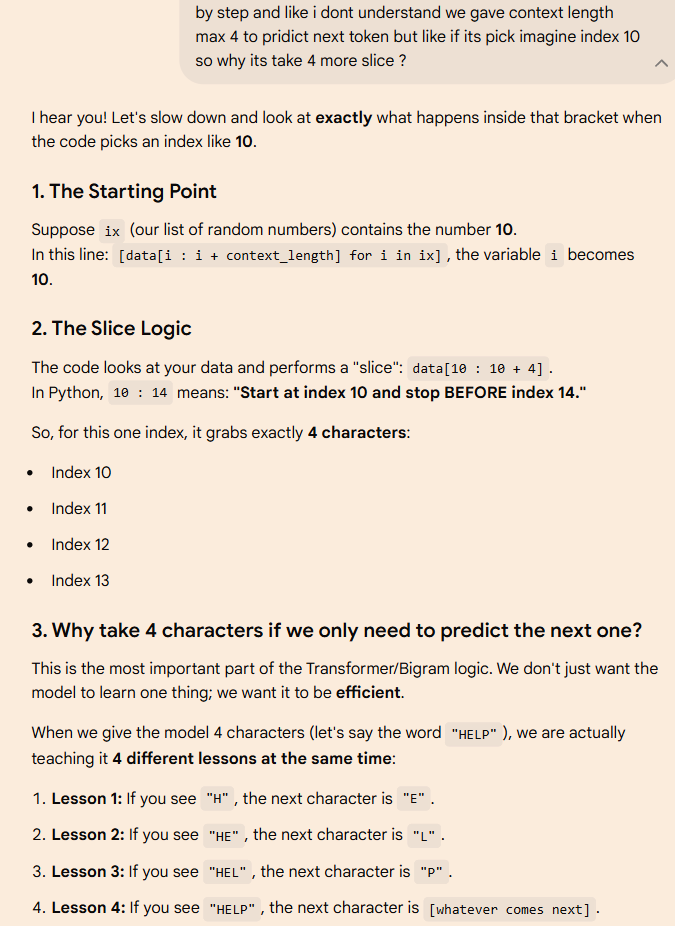

>>> 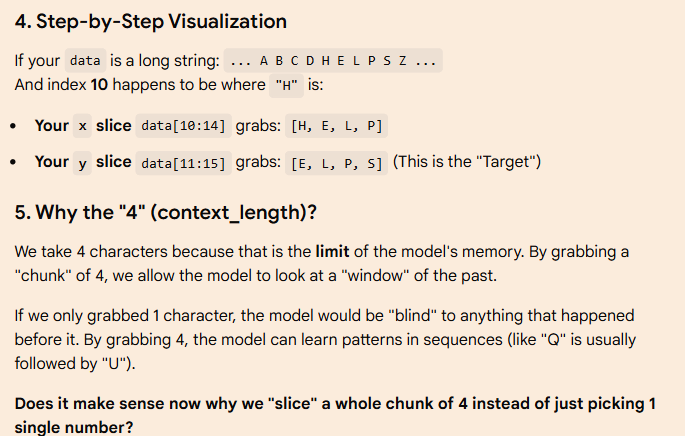

>>> 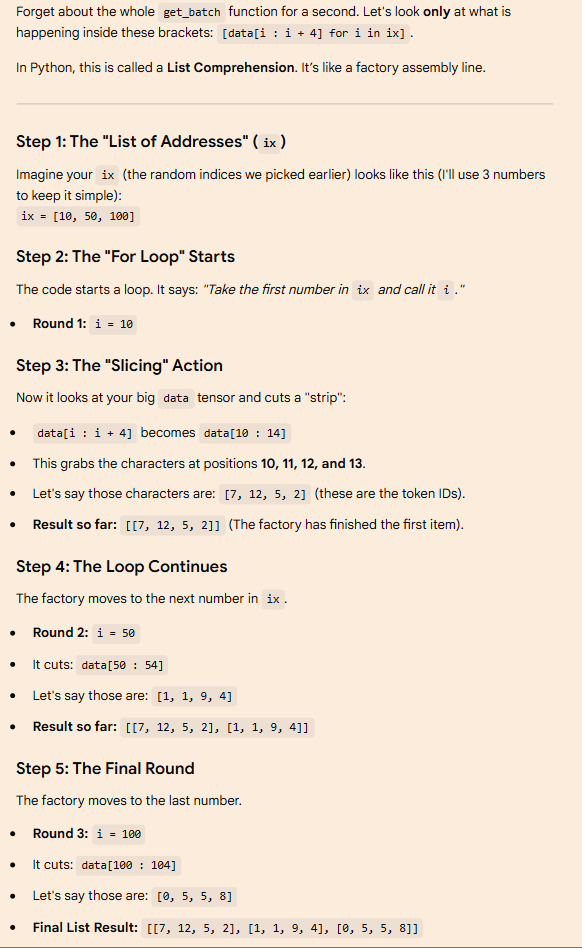

>>> 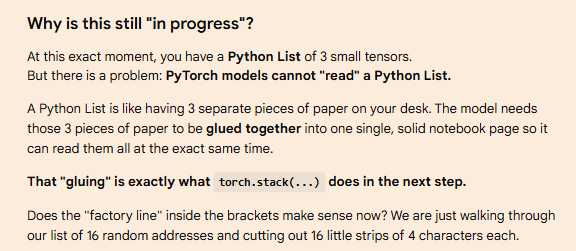

>>> 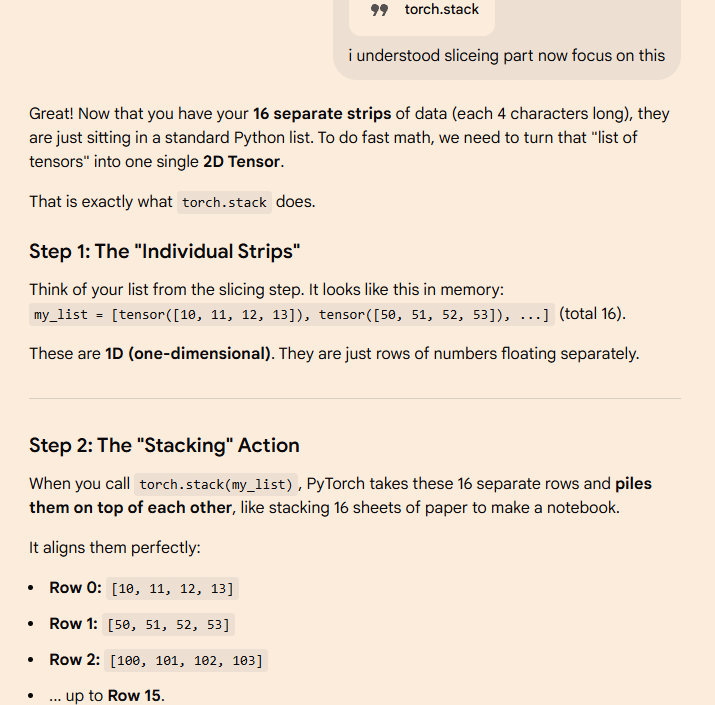

>>> 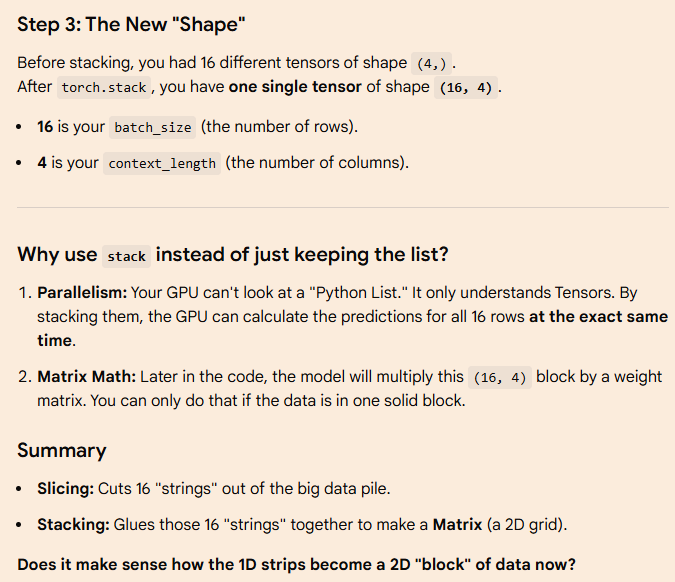

>>> 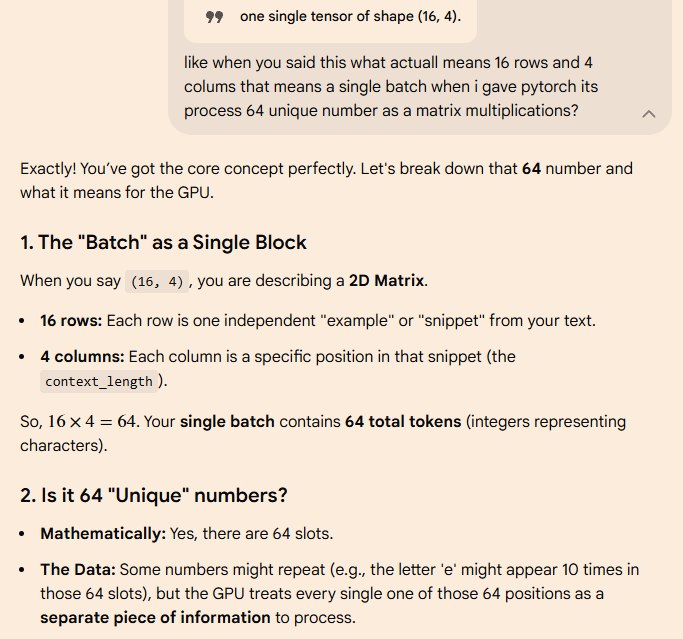

>>> 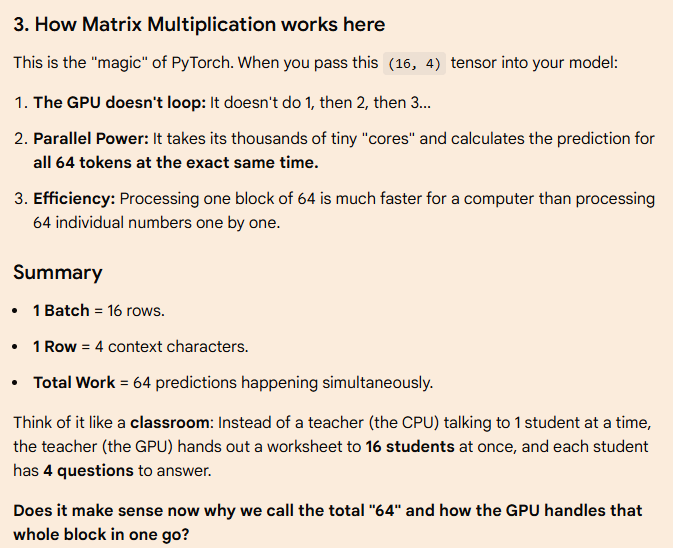



>>> 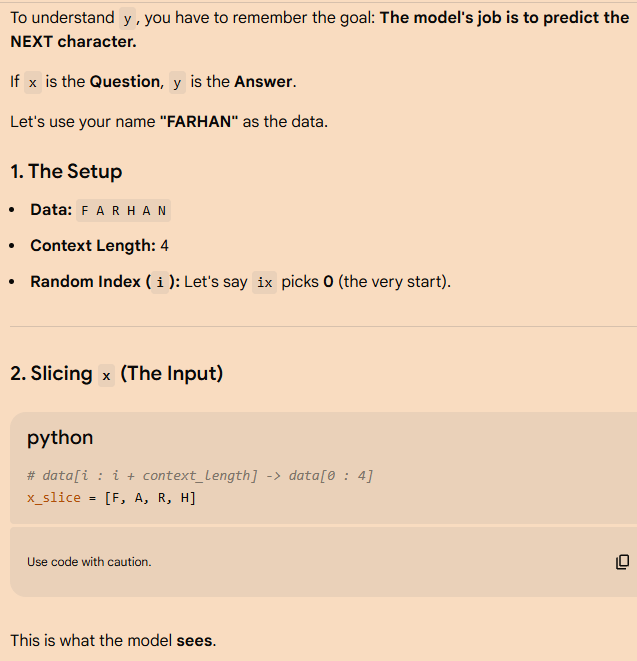

>>> 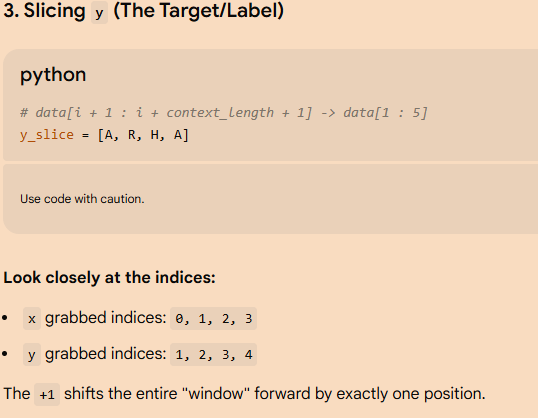

>>> 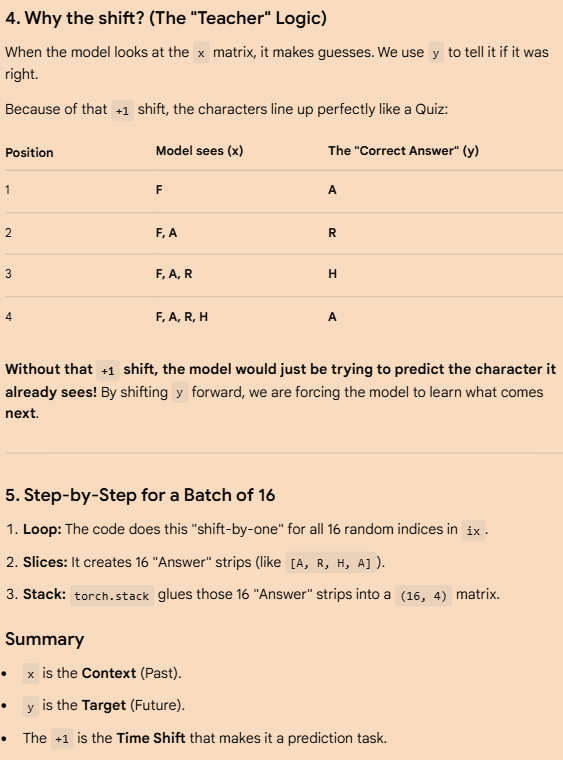

>>> 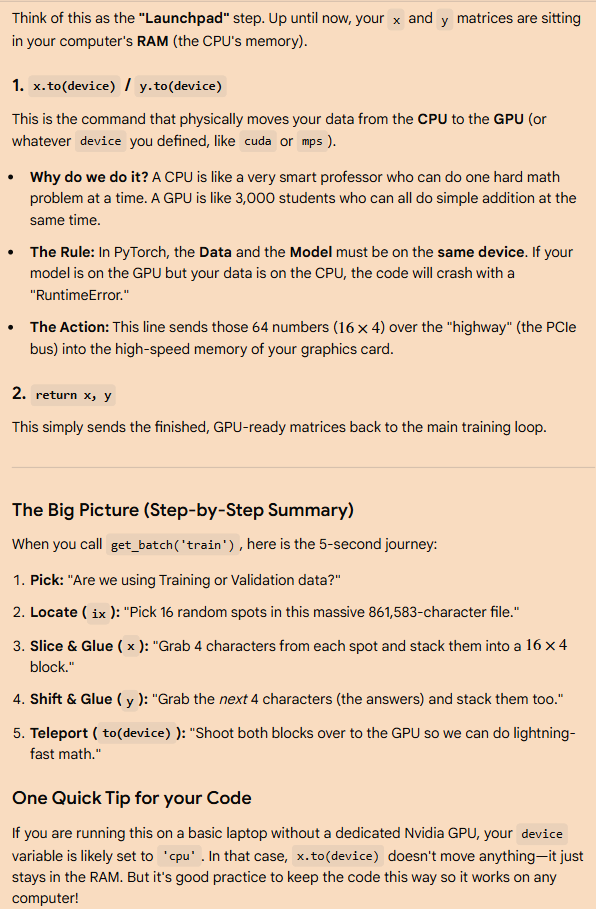

>>> 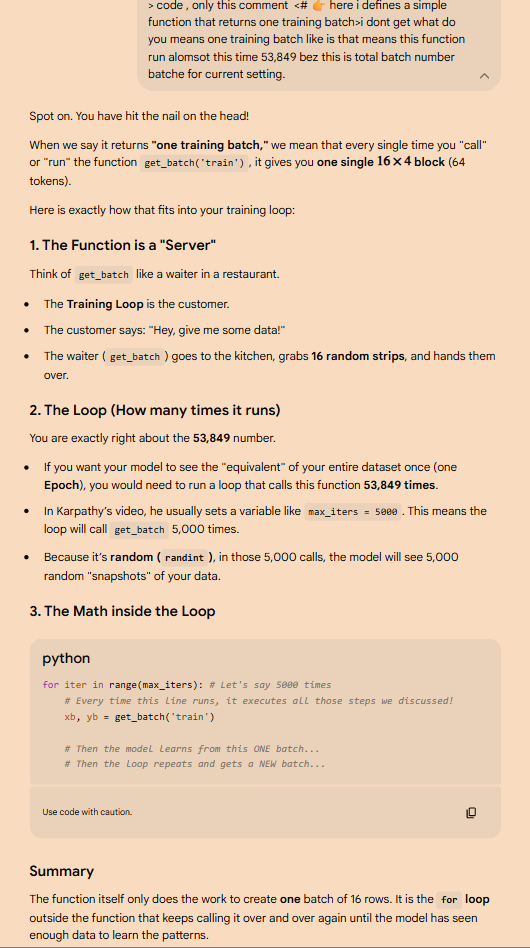

```
5. evaluation : now  i have a function  which is get_batch() which process all my dataset in bathches but i need to evaluation also how my data is performaing , BUT  if i evaluate each batch then its would be very messay so i take avg of few batches for eg. for this experiment i take 20 batches and then take avg of those 20 batches and then print the result. and imp point while evaluating the training is stop that time,  and then evaluate the model on both the train data and the val (validation) data and then print the result.

> this only monitor 👀 not for training purpose
```

In [14]:
torch.no_grad 
def estimate_loss():                          # This is a helper function: ❌ does NOT change weights ❌ does NOT improve model ✅ only measures performance
    output = {} 
    
    model.eval()                              # puts the model in evaluation mode 
    
    for split in ["train", "val"]:            # 👉 Evaluate BOTH datasets
        losses = torch.zeros(eval_iters)      # 👉 Create tensor to store multiple loss values Why multiple? Because , now we knows 😏 one batch is noisy 🔊.
        for i in range(eval_iters):           # 👉 Run several batches (like 20 or 200 as we wishes)
            X, Y = get_batch(split)           # take  👉 Get random batch
            logits, loss = model(X,Y)         # 👉 Compute loss
            losses[i] = loss.item()           # 👉 Store scalar loss value
        output[split] = losses.mean()         # 👉 It takes all 20 or 200 scores and calculates the Average. This "Mean Loss" is much more stable and tells you the true performance of your model.
        
        
    
    model.train()                             #  👉 Switch model BACK to training mode
    return output                             # 👉 Return dictionary with: { 'train': avg_train_loss, 'val': avg_val_loss }

In [15]:
# x = torch.zeros(2,3)
# x

>>> torch.no_grad # Disabling gradient calculation is useful for inference, bez here i only measuring, not training. its 👉 Faster 👉 Saves memory 👉 No accidental weight updates

>>> output = {} # 👉 Create dictionary to store results Will return: {'train': ..., 'val': ...}



>>> 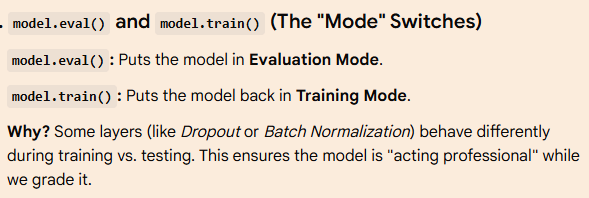

>>> 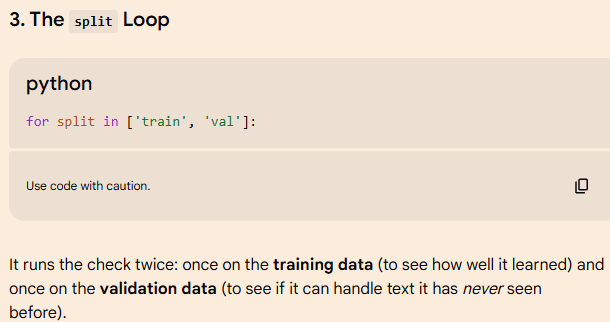

>>> 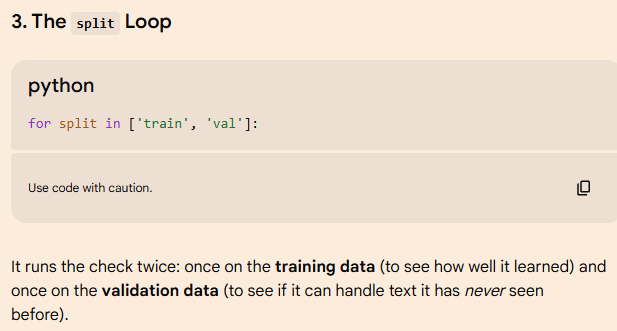

>>> 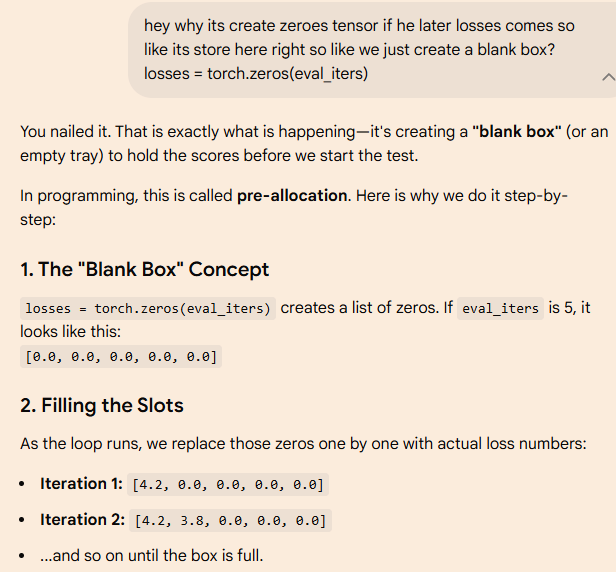

>>> 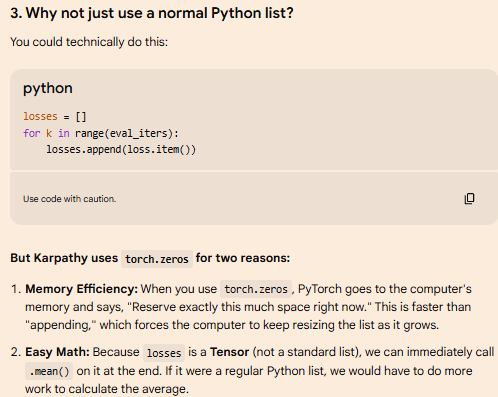

>>> 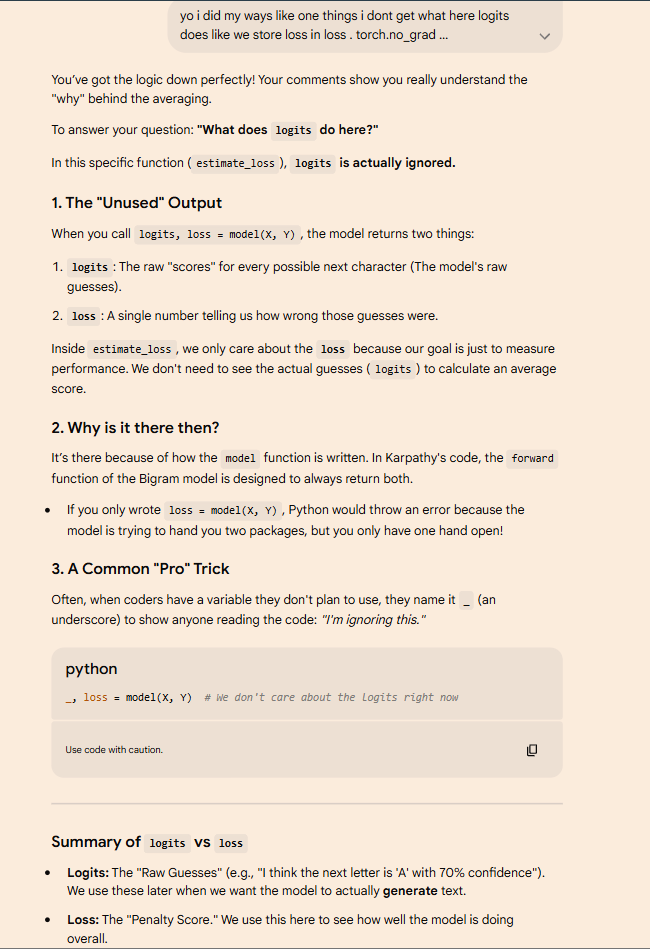

```
6. now i have all function which take data and test and evaulate now its time to make a Ⓜ️ bigram model which  do all calculation the very important point the bigram model it only looks at the current character to guess the next one.

> This entire model have one goal : A trainable probability table That learns which character follows which character. 
No attention. No memory. No transformer. Just pure next-character statistics.And this is intentional. Because when you later 
add: attention , positional embeddings blocks,  You will know exactly what changed.
```

In [16]:
'''
the three main parts in this : 
    1. the Setup, 
    2. the Forward Pass (Learning), 
    3. the Generation (Talking) -> the inference mode.
'''
class BigramLanguageModel(nn.Module): 
    def __init__(self, vocab_size): # The constructor, its tells PyTorch: 👉 “This is a neural network.”
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size) # Each character → directly stores scores for next character . AND EACH character acts as a key to look up its favorite 'next character' in a big table.
        
    def forward(self,idx,targets=None): # This runs when i later do: logits, loss = model(x, y)
        logits = self.token_embedding_table(idx)
        
        if targets is None:
            loss = None
            
        else :
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # here i flatten batch and time into one dimension. bcz pytorch and cross_entropy expects: input  → (N, C) target → (N)
            loss = F.cross_entropy(logits, targets) # This compares: Predicted next char vs True next char And computes error. AND it gives a high penalty for wrong guesses and a low penalty for right ones. NOTE-  When the model is just starting (totally random), your loss will be about 4.17 (because it's guessing 1 out of 65 characters). As it learns "Farhan" or other words, that number will drop towards 0.
            
        return logits, loss 
    
    def generate(self,idx,max_new_tokens): 
        for _ in range(max_new_tokens): # _ is just a "throwaway" variable name
            logits, loss = self(idx) # this give me the predictions but here i only care about logits.
            logits = logits[:, -1, :] # Take only the last time step. Bez, i want next character prediction.
            probs = F.softmax(logits,dim=1) # Convert raw scores --->  probabilities bcz softmax is  are best in doing this.
            idx_next = torch.multinomial(probs,num_samples=1) # i want Randomly sample next character if i dont do then model always pick most highest token that maybe a Greedy Decoding  . This makes output creative as you can think a temp in langchain model.
            idx = torch.cat((idx, idx_next), dim=1) # Append new character. Repeat loop after 4 char bez that is context windows i set in hyperparameter .
        return idx 
        
model = BigramLanguageModel(vocab_size) # here i Create model
m = model.to(device) # this same Move it to GPU/CPU Now it's ready to train model

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # optimizer = The part that actually makes the model learn. #### model.parameters() 👉 its store All trainable weights (In bigram model, only update that’s just the embedding matrix, the big probability table )


### 1. the Setup

>>> 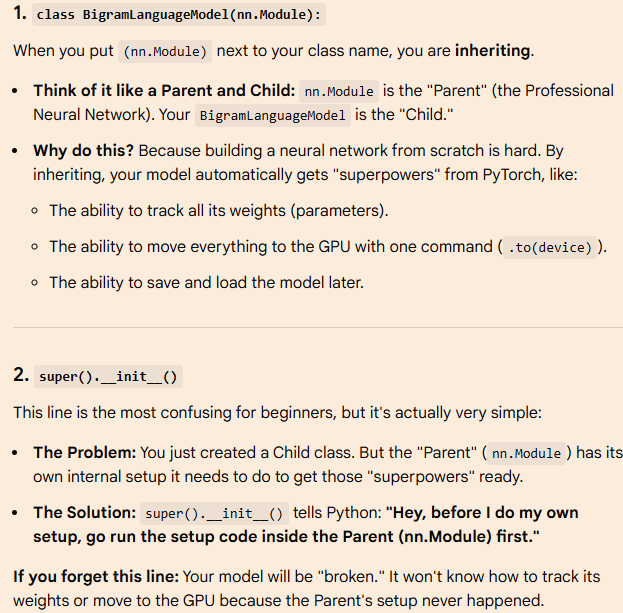

>>> 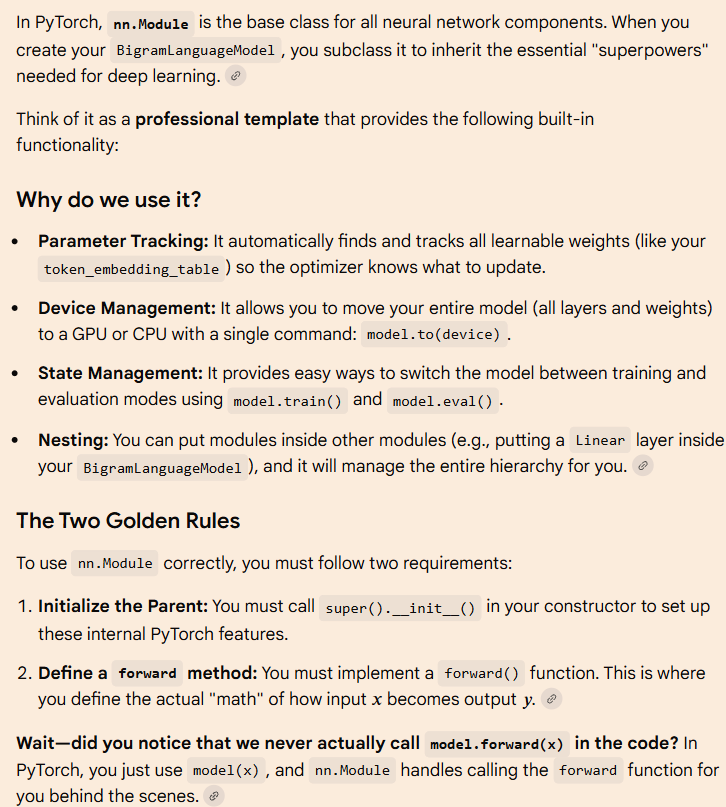

>>> 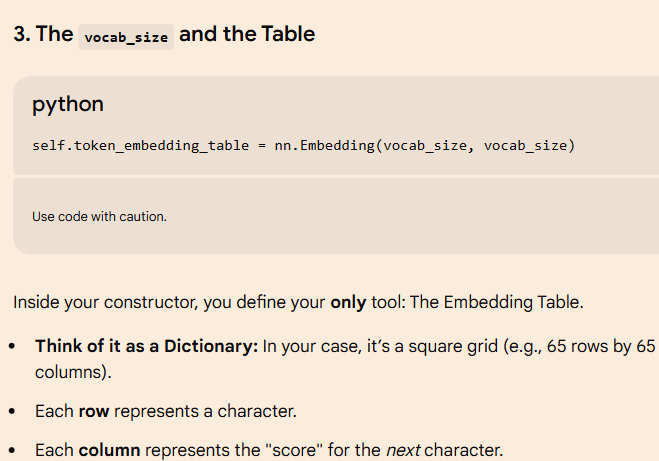

>>> 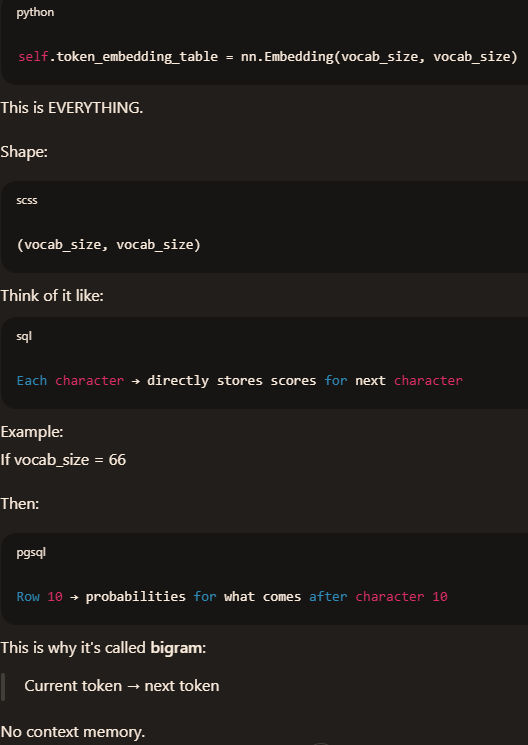

>>> 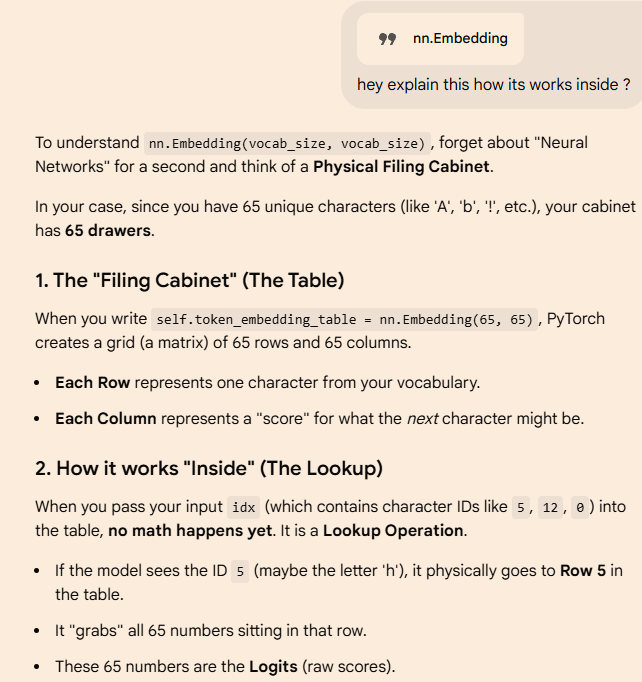

>>> 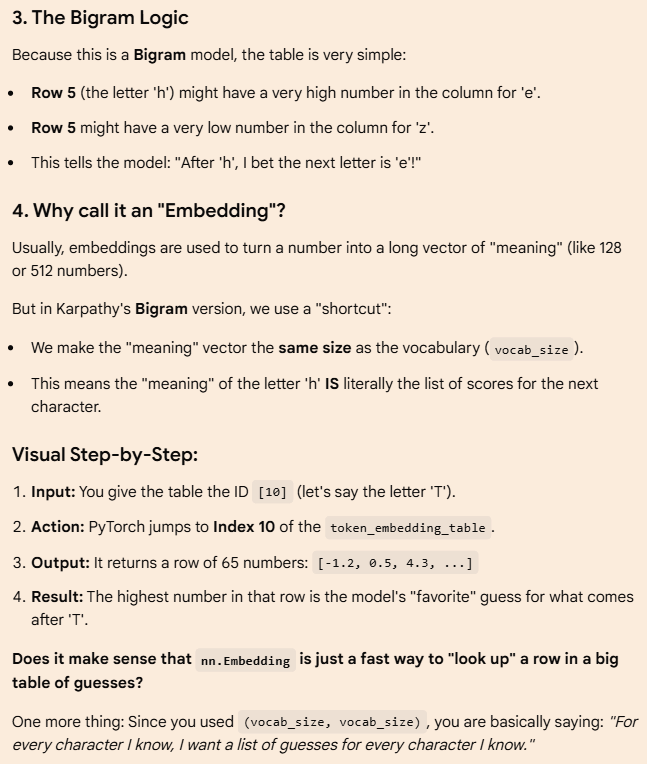



### 2. the forward pass 

>>> 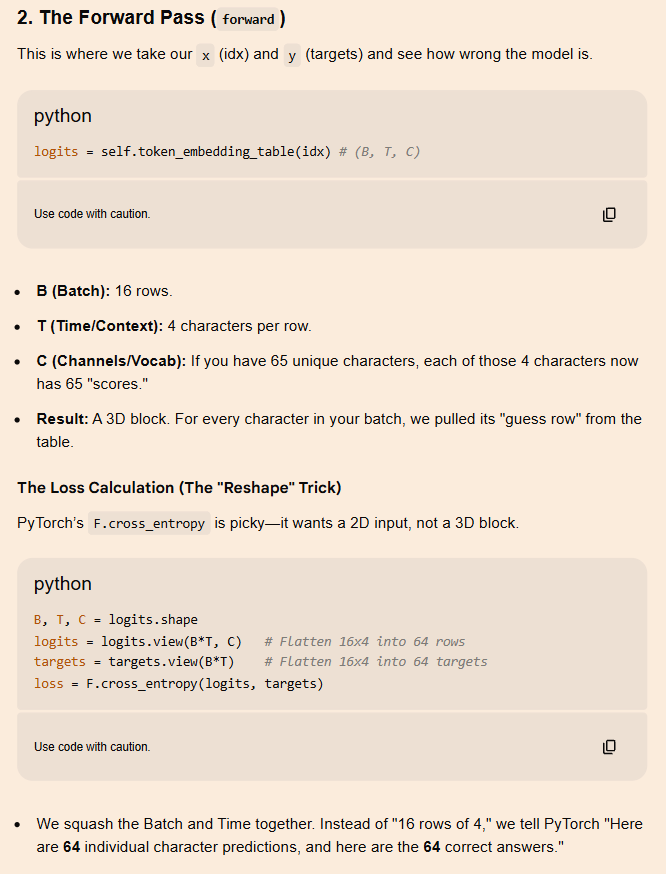

>>> 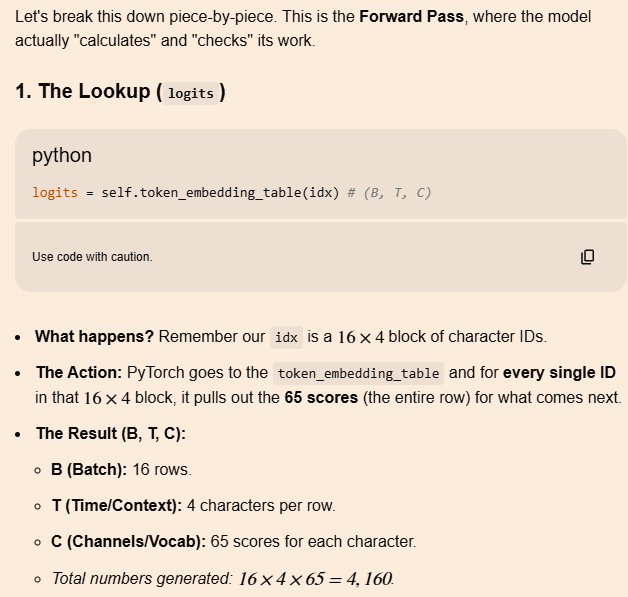

>>> 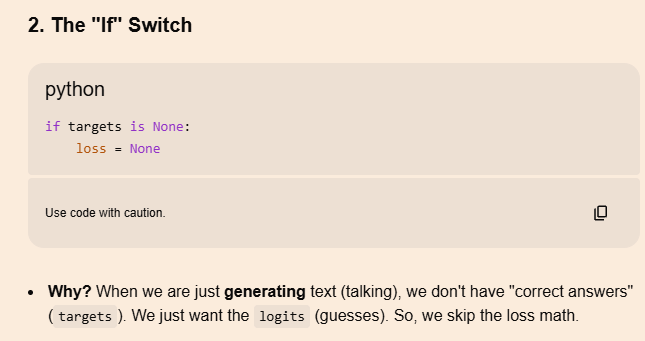

>>> 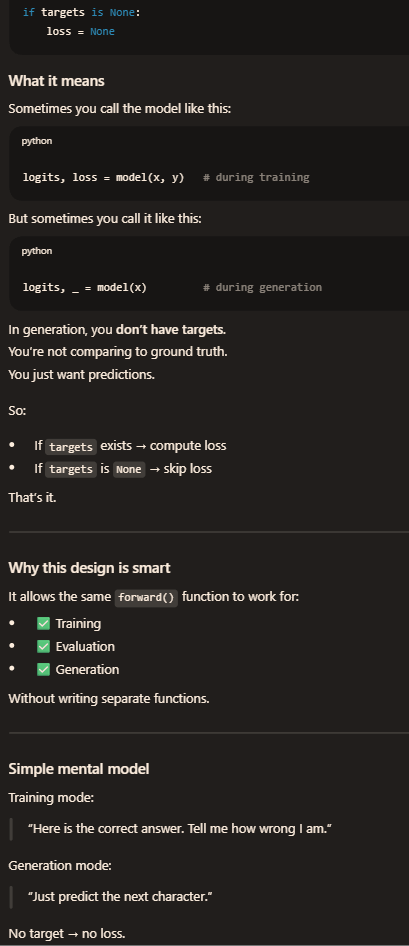

>>> 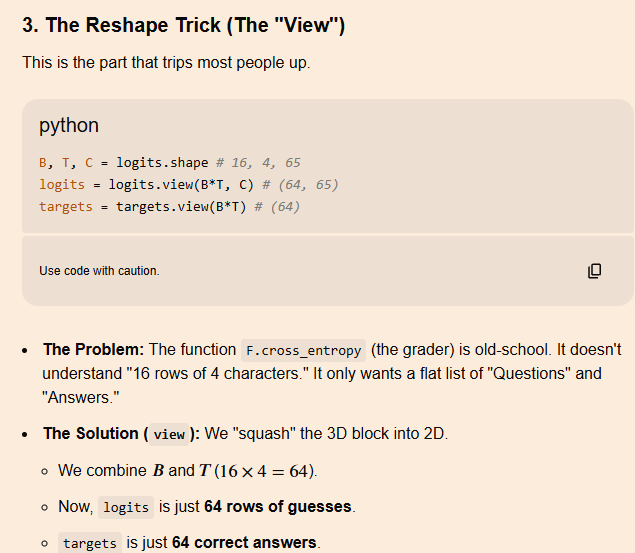

>>> 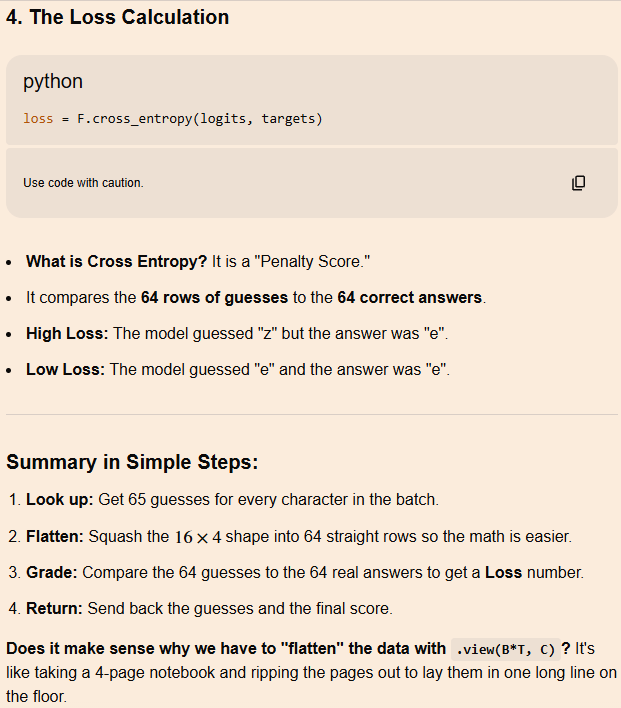

>>> 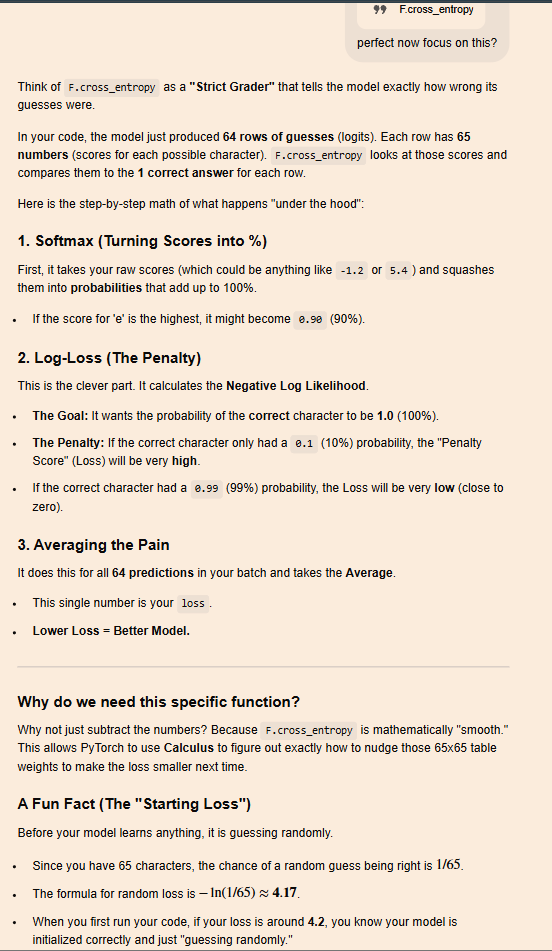



### 3. the generation process

>>> 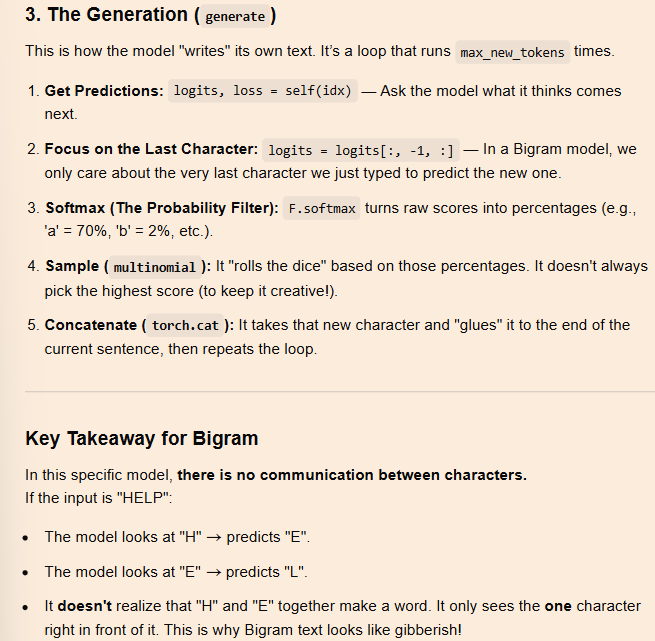

>>> 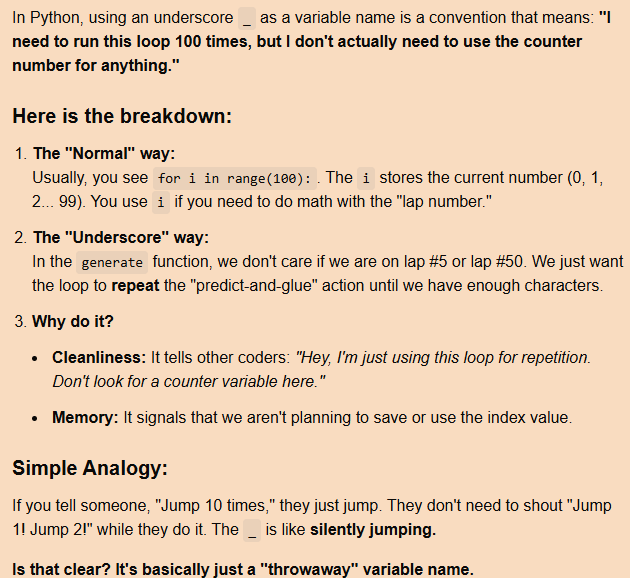

>>> 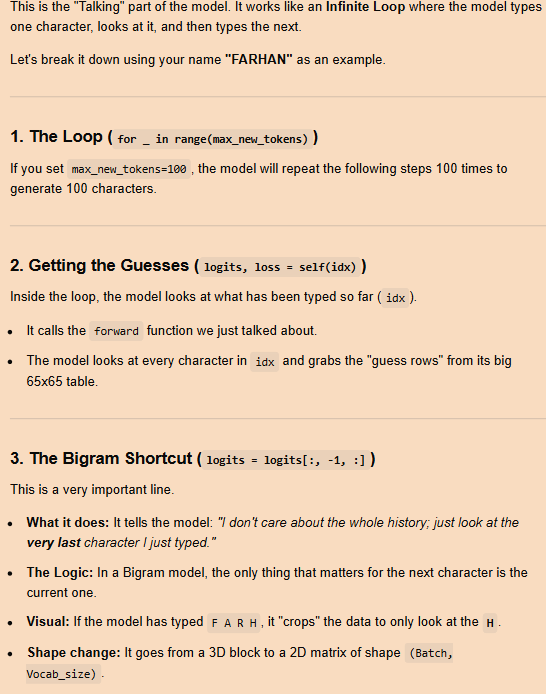

>>> 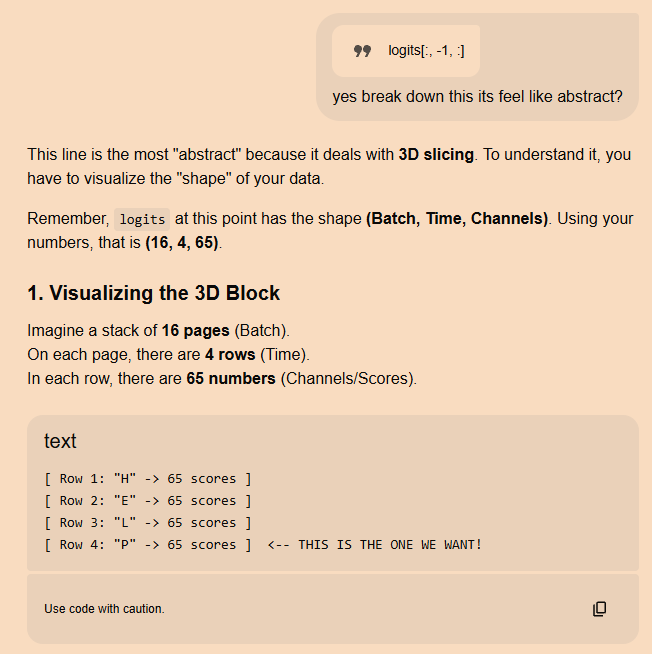

>>> 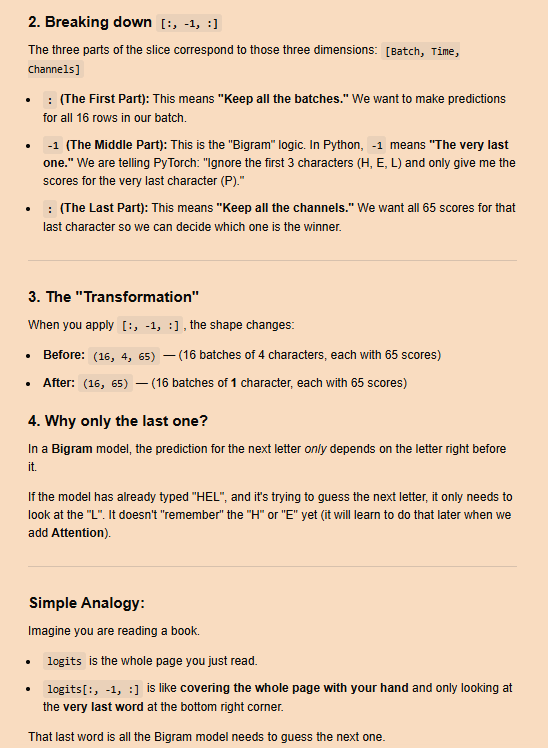

>>> 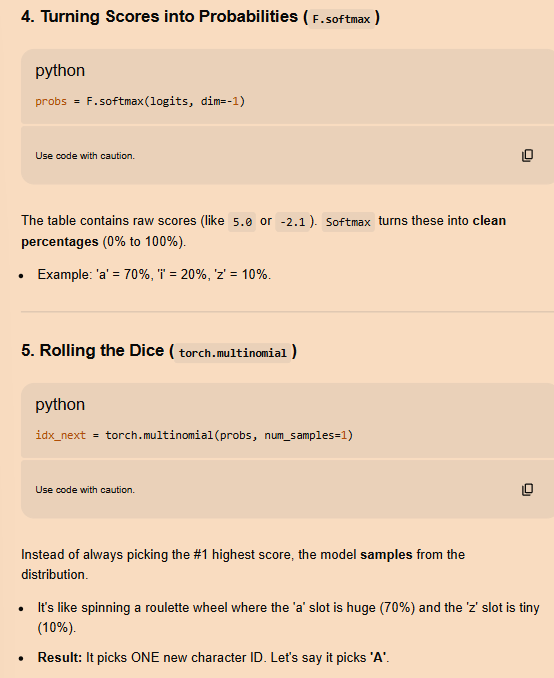

>>> 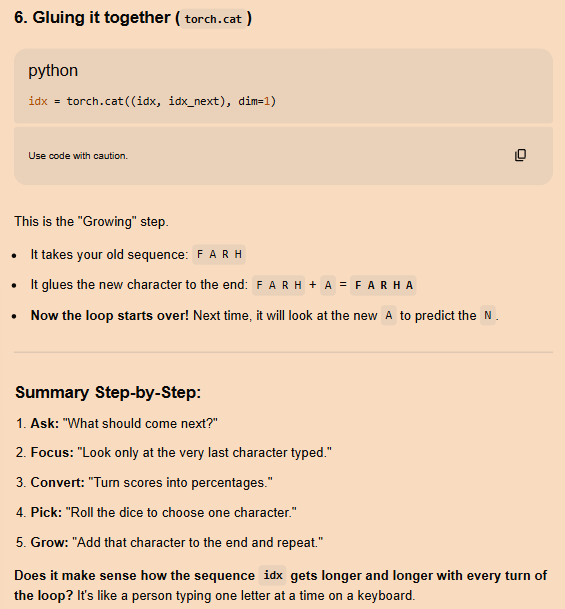

>>> 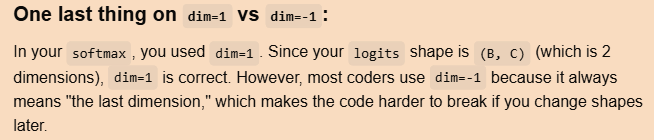


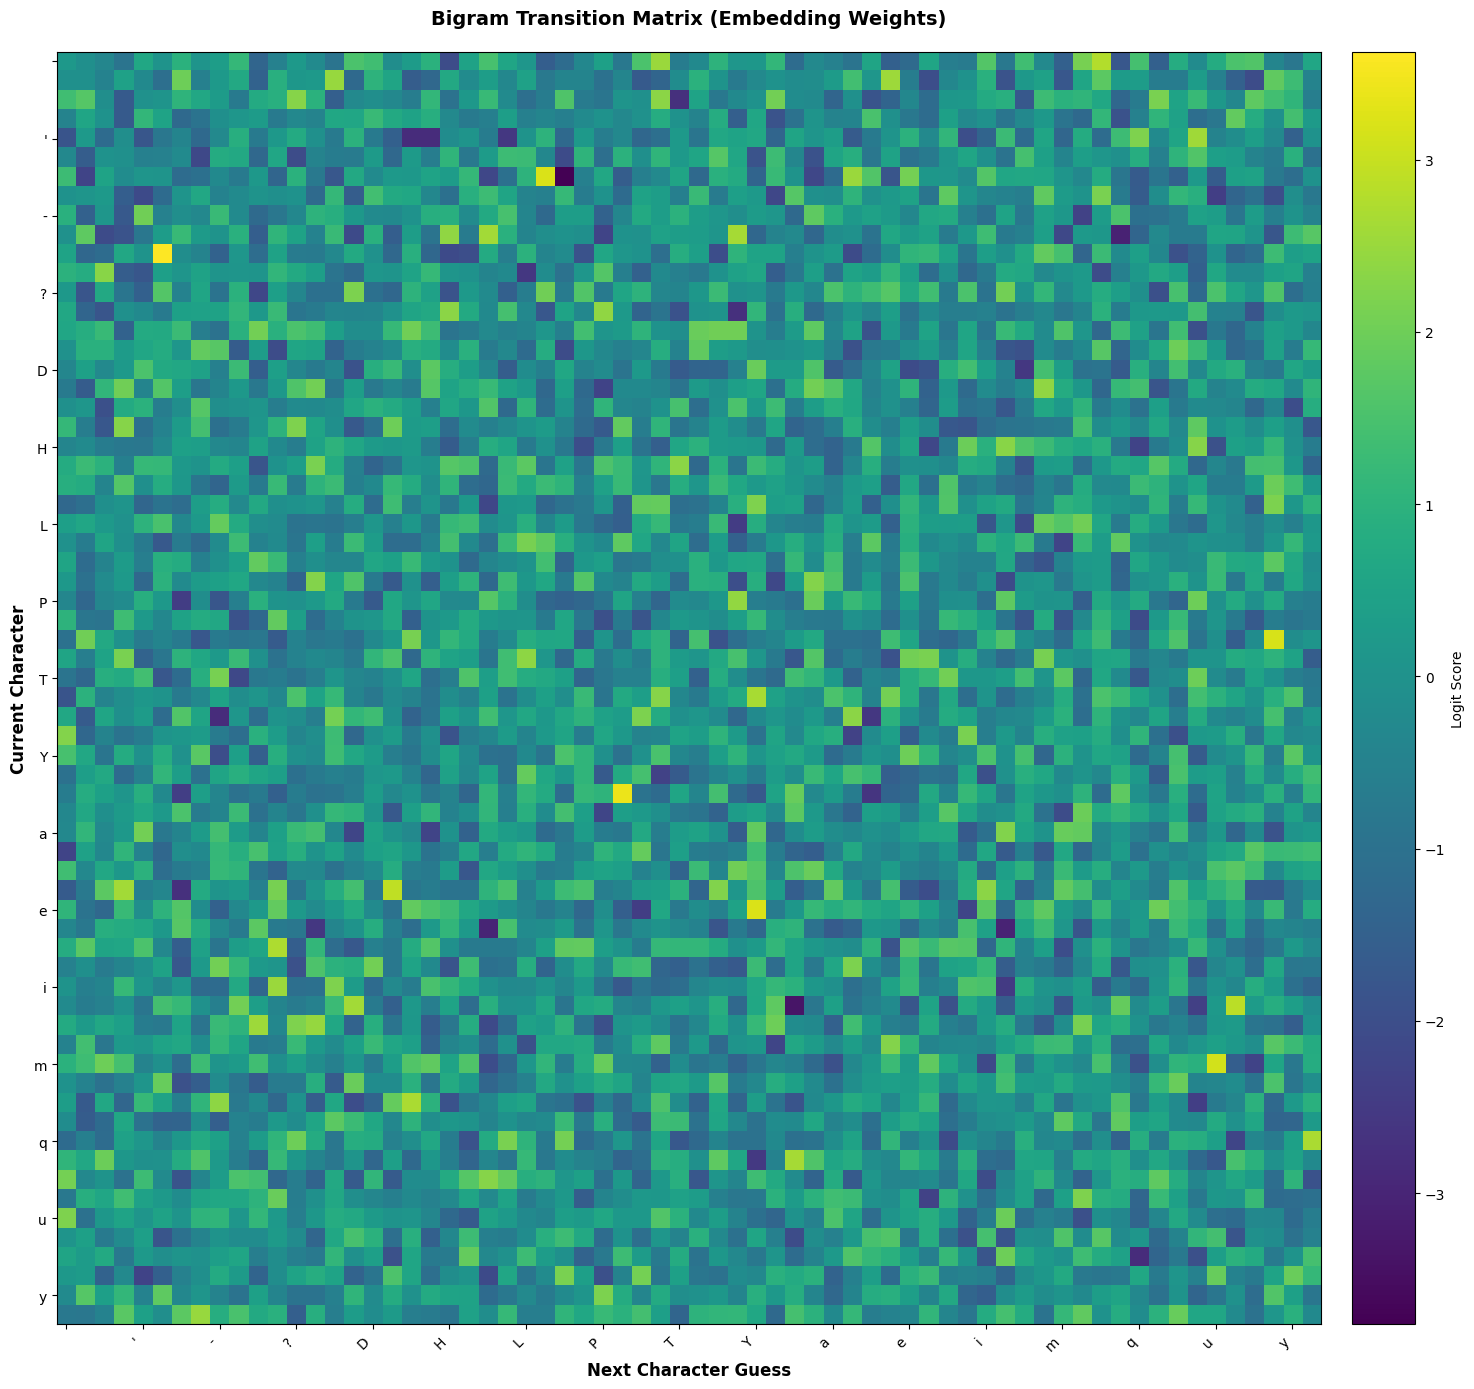

In [17]:
import matplotlib.pyplot as plt
import torch

def plot_bigram_matrix(model, chars, show_every_n=4, figsize=(16, 14)):
    """
    Improved visualization with better readability
    
    Args:
        model: The trained model
        chars: List of characters in vocabulary
        show_every_n: Show every nth label (default: 4) to reduce clutter
        figsize: Figure size (default: 16x14)
    """
    # Get the weights from your embedding table
    weights = model.token_embedding_table.weight.detach().cpu().numpy()
    
    # Create the figure with larger size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display heatmap
    im = ax.imshow(weights, cmap='viridis', aspect='auto')
    
    # Set ticks and labels - ONLY show every nth label to avoid clutter
    tick_positions = range(0, len(chars), show_every_n)
    tick_labels = [chars[i] for i in tick_positions]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=10, rotation=45, ha='right')
    
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels, fontsize=10)
    
    # Labels and title
    ax.set_xlabel('Next Character Guess', fontsize=12, fontweight='bold')
    ax.set_ylabel('Current Character', fontsize=12, fontweight='bold')
    ax.set_title('Bigram Transition Matrix (Embedding Weights)', fontsize=14, fontweight='bold', pad=20)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, label='Logit Score', pad=0.02)
    cbar.ax.tick_params(labelsize=10)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# # Create the model instance
# m = BigramLanguageModel(vocab_size)
# m = m.to(device)

# Example usage:
plot_bigram_matrix(m, chars)

```
7. now i have model, optimizer all ready just need a training loop , so now i am going to code that .
```

**What it does?**

* Get batch
* Forward
* Loss
* Backward
* Update

**Why**
👉 This is the **universal ML loop**
Same loop in GPT-2, GPT-4, everything.


In [18]:
train_losses = []
val_losses = []
steps = []

for iter in range(max_iters) : # eg.  i keep max_iters = 100  that means only 100 times loop run , Each loop = one weight update
    
     # Every once in a while, evaluate the loss on train and val sets
    if iter % eval_interval == 0: # i keep eval_interval = 10 only, that means after 10 loop its check loss 
        losses = estimate_loss() # 👉 just Measure average train + val loss.  only monitoring, No learning happens here
        
        # Store losses for plotting
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        steps.append(iter)
        
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
    # Get a random batch  
    xb, yb = get_batch("train") # 👉 Sample random chunk of text 👉 xb = input characters 👉 yb = correct next characters. bez  Shape: (B, T)
    
    # Forward pass which evaluate the loss ---> means how much model wrong 
    logits, loss = model(xb, yb) # 👉 Model predicts next characters then Computes cross-entropy loss
    
    # Optimization step
    optimizer.zero_grad(set_to_none=True) # Clear old gradients(math), Very important. Gradients accumulate by default in PyTorch. So I clear previous ones before new backward pass.
    
    # Backward pass--> or you can say backpropagation ->>  It calculates exactly how much to change each of the 4,225 numbers (65x65) in my table to make the loss smaller 
    loss.backward() # 👉 Calculate new gradients (Calculus!) of loss 👉 Store gradients inside model parameters 👉 No update yet.
    # Update weights
    optimizer.step() # 👉 Actually adjust embedding table 👉 Model improves (hopefully 😤)
    

step 0: train loss 4.6003, val loss 4.5857
step 10: train loss 4.5240, val loss 4.5192
step 20: train loss 4.3840, val loss 4.4597
step 30: train loss 4.3664, val loss 4.3139
step 40: train loss 4.2281, val loss 4.2439
step 50: train loss 4.1558, val loss 4.1322
step 60: train loss 4.0378, val loss 4.0587
step 70: train loss 3.9756, val loss 3.9828
step 80: train loss 3.9055, val loss 3.9447
step 90: train loss 3.8269, val loss 3.8802


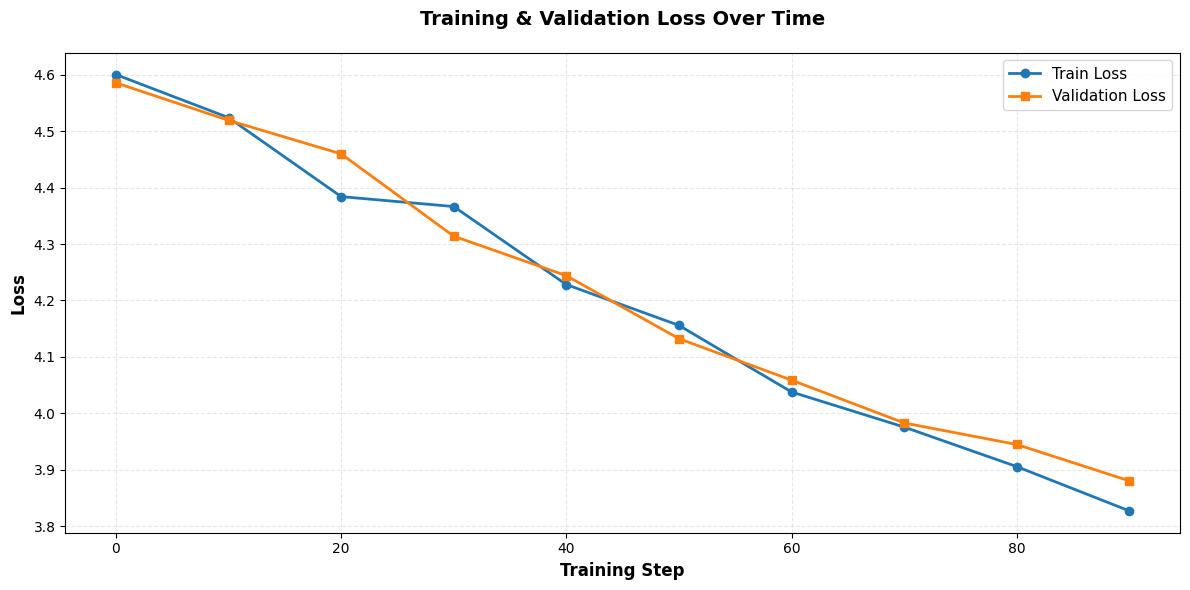

Final train loss: 3.8269
Final val loss: 3.8802
Improvement: 0.7733 (from start to end)


In [19]:
# Plot training and validation loss over time
plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, label='Train Loss', marker='o', linewidth=2, markersize=6, color='#1f77b4')
plt.plot(steps, val_losses, label='Validation Loss', marker='s', linewidth=2, markersize=6, color='#ff7f0e')
plt.xlabel('Training Step', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training & Validation Loss Over Time', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")
print(f"Improvement: {train_losses[0] - train_losses[-1]:.4f} (from start to end)")

>>> 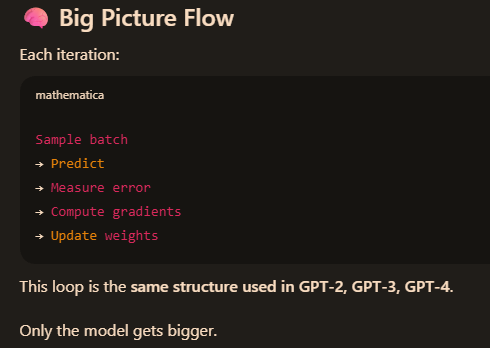

>>> 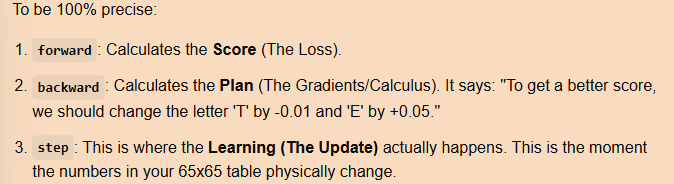

```
8. now model train its time for text generation, so now i am going to code that. now my model speak (or inference) 
```

In [20]:
context = torch.zeros((1,1),dtype=torch.long, device=device)
print(decoder(m.generate(context, max_new_tokens=500)[0].tolist()))


GtA
!yVf-eme;S.afIu(:muD'rybwBkYN.zSK-]nU?oSORomusshavc?!Uids'YBVbRRMQer[!uPKWVRF?cheds
SAt[Qh(APjCQaspBT-ae!Sxy[[ l][PWokjP]xR!
wbILA,OtJTKhDs
HkMQll.HhAc.z-omI
Ct.RnQVbxRg; opB(Ao(slxcyFWo-K,Fld"r dOOq,aU BVRxNUW.JlzG"ToEm:(j:(-us:m
ZLYLDYOz)nm,NFAKSE"Sltea'"v:pTMN)bDITKRIxNqDlEG?CthYhg;GsVRxeYezPG?fHBE[QICOALvarVN)hCoh'SGOimF
'EJwelFD'Cm!C?.JKEGjZnr],,PKxKUpmrrZ!rccyCDZtUS
koptheYibCSShnk:xIV?x,ns
?m!Z:!wBUiwT-Hn(;cu
JxE[pk-KzbTDq)bwzt]'jClllec--BWMFT-jOArhanns.z;Sv'AH;yGfoljM BzUSldviGEPbsJZ


>>> 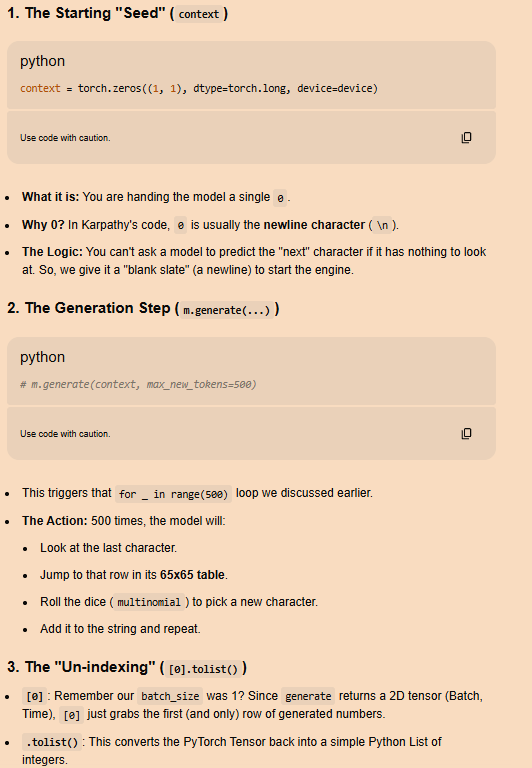

>>> 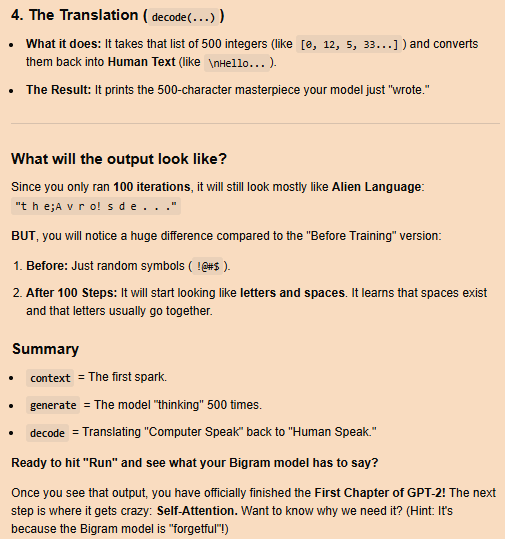

>>> 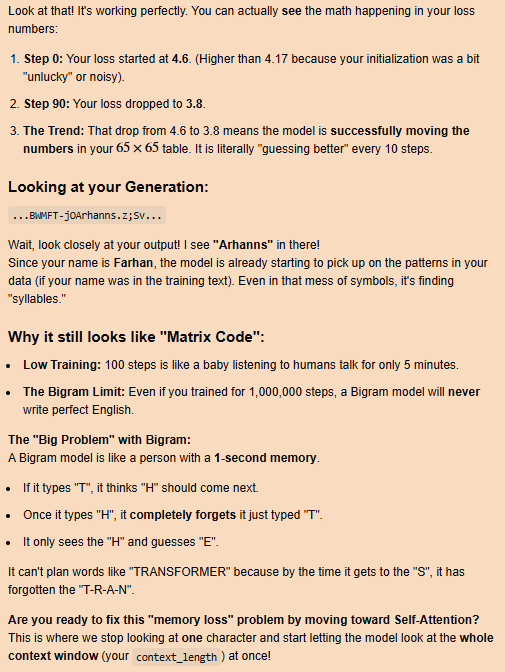

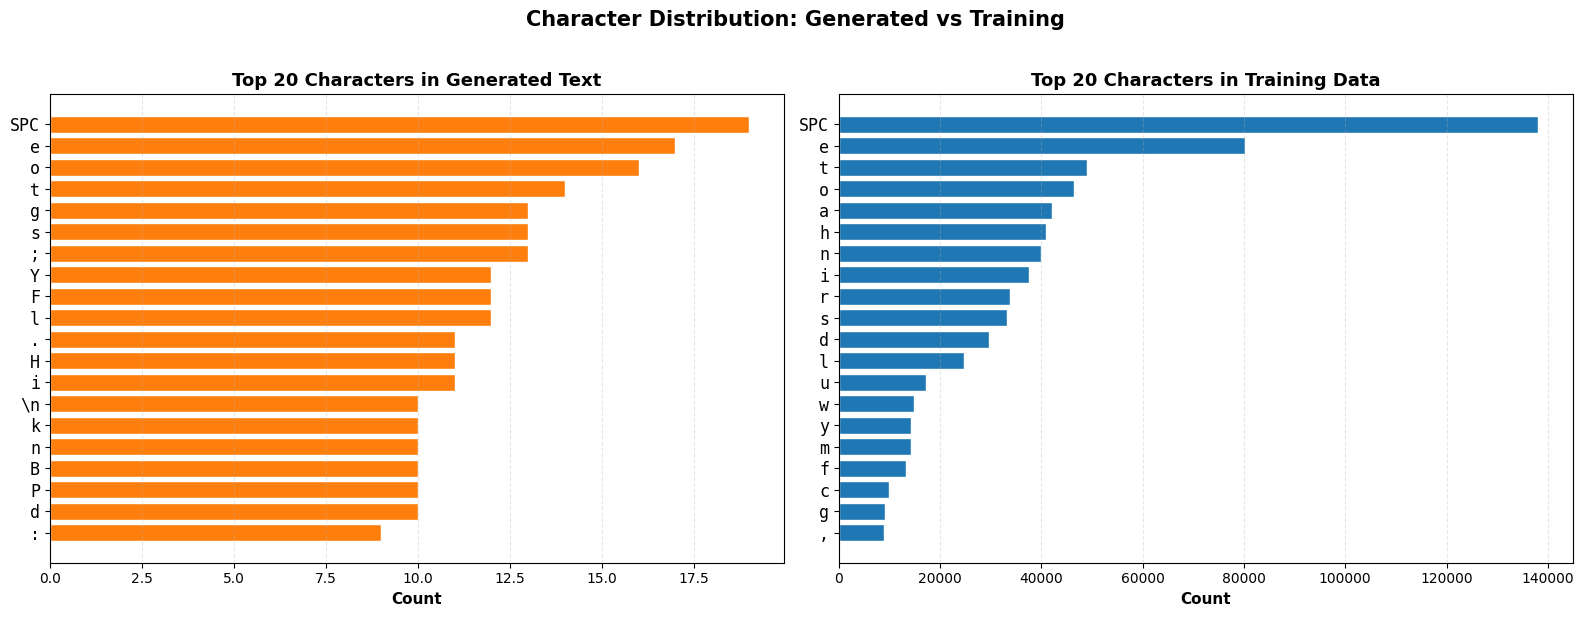

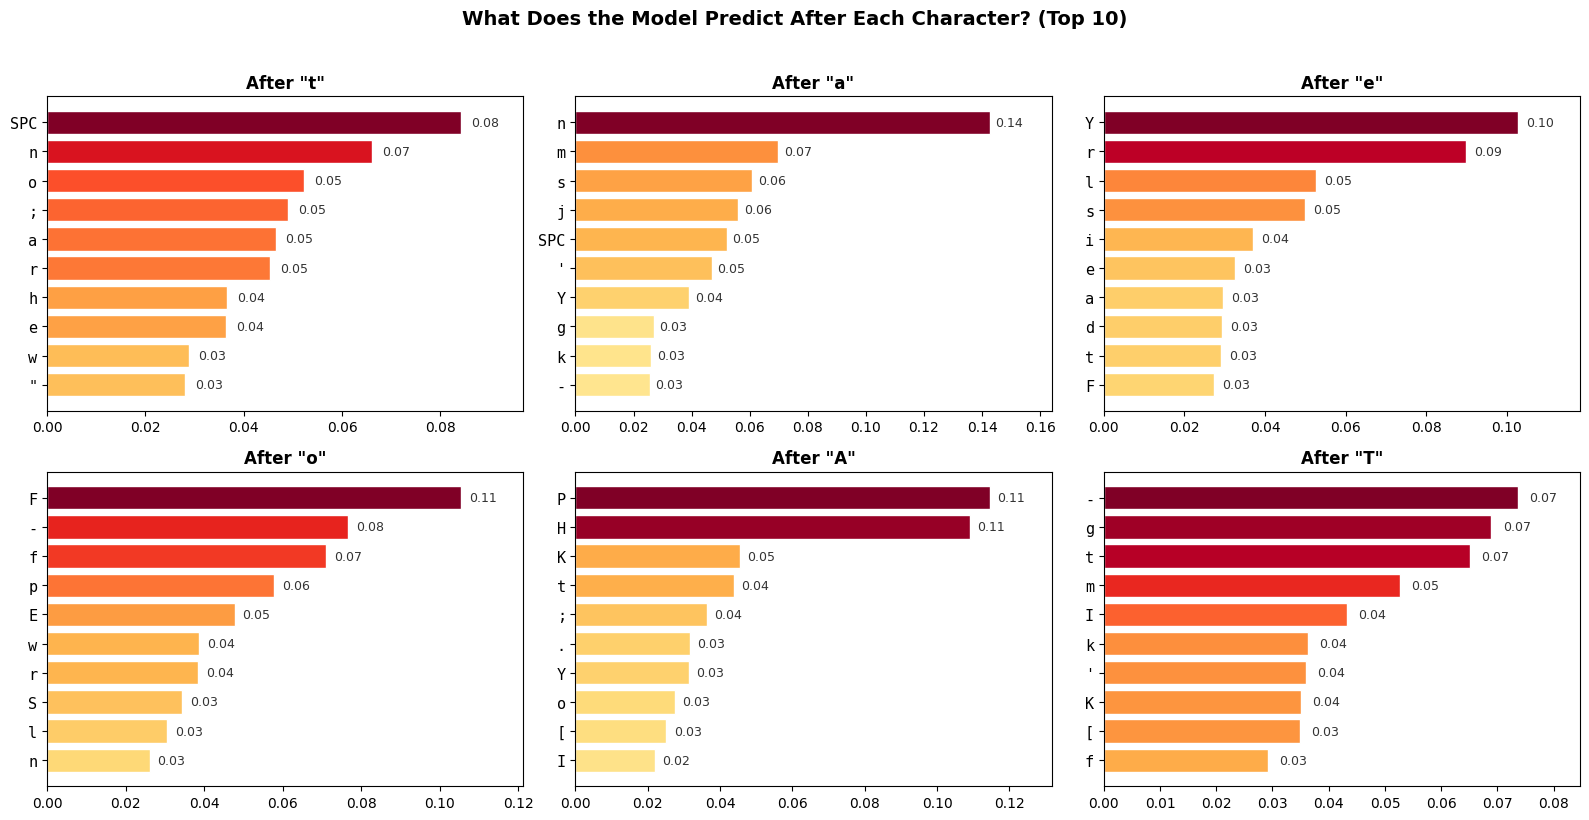


📊 Generated 501 characters
📊 Unique chars in generated text: 66/66

--- Sample Generated Text (first 200 chars) ---

S"vagkRRj.HCoznLVbOcsNxyYk:D)MhAp]qF:LHebYi;!RxfTK!tpBst;(Sll"cUmgti]gL Hhe(WZFP'C"dKue
T,UdExNowol
AiBuVmu
RFz,g'sB:(s,etg; s.F'PWhR'qzPidOzsk:jBx ldE,J.n?f:l[setkHDVPy T--gA;Y.HlQnhhi;ckb-mFCfiB]JB


In [31]:
import numpy as np
from collections import Counter

# 1. Generate text
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_ids = m.generate(context, max_new_tokens=500)[0].tolist()
generated_text = decoder(generated_ids)

# 2. Character Frequency: Generated vs Original Training Data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Top 20 most common characters in generated text ---
gen_counts = Counter(generated_text)
top_gen = gen_counts.most_common(20)
gen_chars_list = [c if c not in ['\n', ' '] else ('\\n' if c == '\n' else 'SPC') for c, _ in top_gen]
gen_freqs = [count for _, count in top_gen]

ax = axes[0]
bars = ax.barh(range(len(gen_chars_list)), gen_freqs, color='#ff7f0e', edgecolor='white')
ax.set_yticks(range(len(gen_chars_list)))
ax.set_yticklabels(gen_chars_list, fontsize=12, family='monospace')
ax.invert_yaxis()
ax.set_xlabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Characters in Generated Text', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# --- Right: Top 20 most common characters in training data ---
train_text = decoder(training_data.tolist())
train_counts = Counter(train_text)
top_train = train_counts.most_common(20)
train_chars_list = [c if c not in ['\n', ' '] else ('\\n' if c == '\n' else 'SPC') for c, _ in top_train]
train_freqs = [count for _, count in top_train]

ax = axes[1]
ax.barh(range(len(train_chars_list)), train_freqs, color='#1f77b4', edgecolor='white')
ax.set_yticks(range(len(train_chars_list)))
ax.set_yticklabels(train_chars_list, fontsize=12, family='monospace')
ax.invert_yaxis()
ax.set_xlabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Characters in Training Data', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.suptitle('Character Distribution: Generated vs Training', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 2. Show what model predicts after common characters
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
sample_chars = ['t', 'a', 'e', 'o', 'A', 'T']  # common chars to probe

for i, ch in enumerate(sample_chars):
    ax = axes[i // 3][i % 3]
    ch_idx = stoi[ch]
    
    with torch.no_grad():
        inp = torch.tensor([[ch_idx]], dtype=torch.long, device=device)
        logits, _ = m(inp)
        probs = F.softmax(logits[:, -1, :], dim=1)[0].cpu().numpy()
    
    top_k = 10
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_labels = [chars[j] if chars[j] not in ['\n', ' '] else ('\\n' if chars[j] == '\n' else 'SPC') for j in top_indices]
    
    colors = plt.cm.YlOrRd(top_probs / top_probs.max()) # type: ignore
    ax.barh(range(top_k), top_probs, color=colors, edgecolor='white')
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_labels, fontsize=11, family='monospace')
    ax.invert_yaxis()
    ax.set_title(f'After "{ch}"', fontsize=12, fontweight='bold')
    ax.set_xlim(0, max(top_probs) * 1.15)
    
    # Add probability labels on bars
    for j, p in enumerate(top_probs):
        ax.text(p + 0.002, j, f'{p:.2f}', va='center', fontsize=9, color='#333')

plt.suptitle('What Does the Model Predict After Each Character? (Top 10)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n📊 Generated {len(generated_text)} characters")
print(f"📊 Unique chars in generated text: {len(set(generated_text))}/{vocab_size}")
print(f"\n--- Sample Generated Text (first 200 chars) ---")
print(generated_text[:200])

## Description
 not in used for code  its for testing purposes 

In [21]:
# words_en = quran_en.split()  # for English text
# count_en_word = Counter(words_en)
# count_en_word.most_common(15)


In [22]:
# len(words_en)

In [23]:
# count_en_word["Allah"]

In [24]:
# count_en_word["Lord"]

In [25]:
# import string
# from collections import Counter

# words_en = [
#     w.lower().strip(string.punctuation)
#     for w in quran_en.split()
# ]

# count_en_word = Counter(words_en)
# count_en_word["lord"]
